# **Hopfield Model and data reconstuction**

### Authors:
- **Ballarin Marco**,   $\textit{1228022, Physics of Data}$
- **Iriarte Delfina**,  $\textit{1231682, Physics of Data}$
- **Segalini Beatrice**, $\textit{1234430, Physics of Data}$
- **Magenya Joemah**,   $\textit{1233392, Physics of Data}$

### Supervised by:
- Professor Baiesi Marco, marco.baiesi@unipd.it

Artificial Neural Networks (ANN) are computational techniques that aim to realize a very simplified model of the human brain. In this way, ANN try to learn tasks mimicking the behavior of brain, which is composed of a large set of elements, specialized cells called neurons. Each single neuron is a very simple entity but the power of the brain is given by the fact that neurons are numerous and strongly interconnected between them. The human brain is one of the most computationally efficient device that is why in the late years a lot of effort has been done in order to develop an artificial version of it, as a matter of fact companies like Telsa motors are developing self driving cars which are based on ANN to implement the behavior of the human brain in computer systems. 

The easiest way to represent a neuron is either "on or off" with the synapsys either eccitative or inibitive. We can easily map the neural network into a spin system by mapping neurons in spins $\{s_i\}_{i=1,\cdots,N}$ and synapsys into the magnetic coupling $J_{ij}$.
By a specific representation of these coupling costant we can define the Hopfield model.

## The Hopfield Model

The Hopfield model is a fully connected neural network able to recall stored memories starting from a noisy or distorted input. The Hopfield network consists of $N$ neurons connected through symmetric bidirectional links. The neuron interactions are encoded in the connection matrix, a $N × N$ real symmetric matrix without self-interaction terms, whose $J_{ij}$ entries define the weight of the connection between neuron $i$ and $j$. 

The model respect the following mapping:

$$
n = \{0,1\} \longrightarrow s = \{-1,1\}    
$$
                                   
where $n$ is the neuron and $s$ the spin. 
The correct transformation of this mapping is:

$$
\begin{equation}
s = f(n) = 2n-1
\end{equation}
$$

We define the synapses as:
$$
J_{ij}=\begin{cases}
+1 & \mbox{ excitatory synapses} \\
-1 & \mbox{ inhibitory synapses}
\end{cases}
$$

A neuron is activated if it receives a sufficient number of active impulses, and we can compute these impulses as follows:
$$
\begin{equation}
h_i(t) = \sum^N_{j=1,j\neq i} J_{ij}(s_j(t)+1)
\label{eq:h} 
\end{equation}
$$
It is important to notice that $j\neq i$ since the neuron $\textit{does not}$ interacts with itself.
To decide if these impulses are sufficient to activate the neuron, we apply a non-linear function to the impulses:
$$
\begin{equation}
s_i(t+1)=sign{\left(h_i(t)-\theta_i\right)}
\end{equation}
$$
where $\theta_i$ is a fixed threshold. We choose this threshold in a way that is useful for the calculations:
$$
\theta_i = \sum^N_{j=1,j\neq i} J_{ij}.
$$
By applying this threshold, we obtain the following $\textbf{update rule}$, which we will be using below in the code:
$$
\\
\begin{equation}
s_i(t+1)=sign{\left(\sum^N_{j=1,j\neq i} J_{ij}s_j(t)\right)}
\label{eq:upd}
\end{equation}
\\
$$
The $\textbf{Hopfield model}$ that we will exploit in our work consists of a specific choice for the synapses ($\textit{magnetic couplings}$):
$$
\\
\begin{equation}
\begin{cases}
J_{ii}=0 & \mbox{ known as Hebb rule} \\
J_{ij}=\frac{1}{N}\sum_{\mu=1}^{p} \xi^\mu_i\xi^\mu_j
\end{cases}
\label{eq:hop}
\end{equation}
\\
$$
where the $\vec{\xi^\mu}$ are $p<<N$ excitatory pattern with $\xi^\mu_i=\{+1,-1\}$.
This choice encodes these patterns in the couplings and gives to the system some interesting properties:
- If the system starts from a configuration equal to a pattern $\vec{\xi^\mu}$ and we apply the update rule of Eq $\eqref{eq:upd}$, it remains in that pattern $\forall t$.
- By solving the system from a statistical mechanics point of view, it turns out that all the minima of the system corresponds to the patterns.

It is instructive to see the proof of the stability of the patterns.
$$
s(1)=sign{\left(\sum^N_{j=1} J_{ij}s_j(0)\right)}\overset{s_j(0)=\xi^\mu_j}{=}
sign{\left(\sum^N_{j=1} \frac{1}{N}\sum^p_{\nu=1}\xi_i^\nu\xi_j^\nu\xi_j^\mu\right)} 
\\=sign{\left(\sum^N_{\nu=1}\xi_i^\nu\frac{1}{N}\sum^p_{j=1}\xi_j^\nu\xi_j^\mu \right)} 
=sign{\left(\sum^N_{\nu=1}\xi_i^\nu(\delta_{\mu\nu}+O(N^{-\frac{1}{2}}) \right)}
\simeq sign\left(\xi^\mu_i \right)=\xi^\mu_i
$$
And so the property enuciated before holds.

From now on we will talk about spins and not neurons anymore.

This model take into account fully connected systems, where each spin is connected to all the others. But what happen if we consider an interaction lenght $R$? It is an interesting question to look at how the results vary with this assumption.

Moreover, this type of system does not need training, differently to other neural networks, and so it can be really interesting if the results are good.

In conclusion, the aim of this work is to start from this theoretical model and further analyze it, by studying the stability of the patterns, the recovering of corrupted ones and simulate its dynamics with a Montecarlo method.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy as scp
from copy import deepcopy
import time as time
import pylab as pb 
from mpl_toolkits.mplot3d import Axes3D


## Stability of the model

In this first section, we are going to discuss about the stability of the Hopfield model, in both MF and NMF, especially focusing on these main points:

- study of the dependence of error of the algorithm with respect to number of patterns; 
- time scaling with size of the system;
- time scaling with the number of patterns;
- dependence of the error on the number of neighbors. 


In [2]:
# Parameters
L = 10   # Length of the edge of the image
N = L**2 # Number of spins 
p = 5    # Number of patterns
MF = 0   # Use or not the Mean Field strategy: if MF = 1 uses MF, if MF = 0 only spins at
         # a distance R interacts
R = 3    # The 3-nearest neighbor interacts
np.random.seed(1234) # Seed to make the random process reproducible

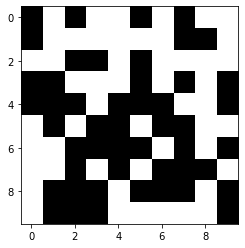

In [3]:
# Patterns
def random_patterns(N,p):
    xi = np.random.randint(0,2,N*p).reshape(p,N) # Each line is a pattern
    xi[xi==0]=-1
    return xi

xi = random_patterns(N,p)
idx = np.random.randint(0,p)
plt.imshow(xi[idx].reshape(L,L),cmap='Greys') # This is an example of pattern 
# -1 = white, +1 = black

In [4]:
# Coupling constant
# Row i is the connections of the i-th neuron with the others.
# Note that the Hopfield model requires Jii=0
# Note that J is a symmetrical matrix (J=J.T)

def MF_coupling(xi,N):
    J = 1/N * np.array( [ (xi[:,i]*xi[:,j]).sum() for i in range(N) for j in range(N) ] )
    J = J.reshape(N,N)        
    for i in range(len(J)):
        J[i,i] = 0
    return J

def R_coupling(xi,N,R):
    J = MF_coupling(xi,N)
    L = int(np.sqrt(N))
    for i in range( J.shape[0] ):
        J_temp = J[i].reshape(L,L)
        for j in range(L):
            y = (i%L -j)**2 
            for k in range(L):
                if np.sqrt( (i//L - k)**2 + y ) > R: J_temp[j,k] = 0
        J[i] = J_temp.reshape(1,N)
    return J

if MF: J = MF_coupling(xi,N)
else: J = R_coupling(xi,N,R)

In [5]:
# Update rule

def update(sys1):
    sys = deepcopy(sys1)
    N = len(sys)
    temp = np.zeros(N) 
    for i in range(N):
        for j in range(N): 
            temp[i] +=  J[i][j]*sys[j]
        if temp[i] == 0: temp[i] = 2*np.random.randint(0,2)-1
    sys = np.sign(temp)
    return np.sign(sys)

def deterministic_hopfield(sys, t): #t is the number of iterations
    for i in range(t):
        sys = update(sys)
    return sys

#we define the error as the number of different pixels between a pattern and the image 
#normalized to the system size
def error_im(xi_idx, sys): #xi_idx is the "correct" pattern
    wrong_pixels = (np.abs( sys-xi_idx )/2).sum()
    return wrong_pixels/len(sys)

def assign_pattern(xi,sys): #xi are the patterns
    errors = [ error_im(i,sys) for i in xi ]
    correct = np.argmin(errors)
    return correct 

#calculate score and error for all the possible patterns
def total_error(xi,t):
    errors = []
    prediction = []
    for mu in range(len(xi)):
        sys = deterministic_hopfield(xi[mu],t)
        errors.append( error_im(xi[mu],sys) )
        if assign_pattern(xi,sys)==mu:
            prediction.append( 1 )
        else: prediction.append( 0 )
    errors = (np.array(errors)).mean()
    prediction = np.array(prediction).sum()/len(xi)
    return errors, prediction

The error of the algorithm is 0.030000
The algorithm recognised the pattern 2 and the correct pattern is 2


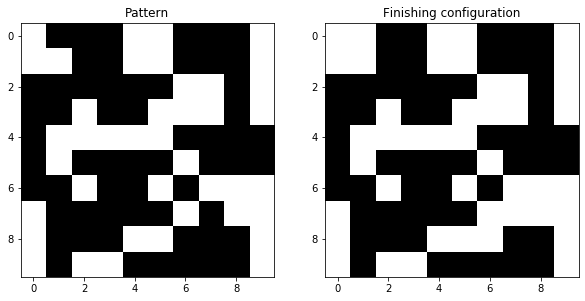

In [6]:
# actual algorithm

idx = np.random.randint(0,p) #randomly chosen pattern
sys = deepcopy(xi[idx])

sys = deterministic_hopfield(sys,100)
wrong_pixels = error_im(xi[idx],sys)
assigned_pattern = assign_pattern(xi,sys)

fig, ax = plt.subplots(1,2, figsize = (10,6))
ax[0].set_title('Pattern')
ax[0].imshow(xi[idx].reshape(L,L), cmap='Greys')
ax[1].set_title('Finishing configuration')
ax[1].imshow(sys.reshape(L,L), cmap='Greys')
print('The error of the algorithm is %f' %(wrong_pixels))
print('The algorithm recognised the pattern %i and the correct pattern is %i' %(assigned_pattern,idx))

## Analysis

At first we studied how the performances of the algorithm depended on the number of patterns $p$. The system size was fixed to $L=16$ for the first case, then we changed it to other sizes in order to compare the error and score. Both the Mean Field model (MF) and the Non Mean Field one (NMF) have been studied.

In [ ]:
L = 16
N = L**2

P = np.arange(5,N/2,20)
scores_16 = [[],[]]
errors_16 = [[],[]]

for MF in range(2):
    for p in P: 
        p = int(p)
        xi = random_patterns(N,p)
        if MF: J = MF_coupling(xi,N)
        else: J = R_coupling(xi,N,R)
        err, pred = total_error(xi,30)    
        scores_16[MF].append( pred )
        errors_16[MF].append(err)

figp, axp = plt.subplots(1,2, figsize=(14,6))
axp[0].set_title('Dependance of the error by number of pattern p')
axp[0].set_xlabel('Number of pattern p')
axp[0].set_ylabel('Average error along the p patterns')
axp[0].plot(P,errors_16[0],  '--bo', label='Error, no MF')
axp[0].plot(P,errors_16[1], '--go', label='Error, MF')
axp[0].legend()

axp[1].set_title('Dependance of the prediction of the correct pattern by number of pattern p')
axp[1].set_xlabel('Number of pattern p')
axp[1].set_ylabel('Fraction of pattern correctly predicted')
axp[1].plot(P,scores_16[0], '--bo', label='Score, no MF')
axp[1].plot(P,scores_16[1], '--go', label='Score, MF')
axp[1].legend()

<img src=".\Images\stability_p_error_and_scores.png">

The dependance of error with patterns generally follows an increasing tendency at the beginning of the curve, which then flatters, reaching a plateau. The growth is particularly steep in the case of the NMF model, which reaches its maximum within the first $40$ patterns. It is instead less pronounced for the MF theory: here the highest value ($\approx 0.25$) is reached only after about $70$ patterns. The plateau of the NMF graph is, on the contrary, more stable, showing almost no oscillation around the value of $0.15$, which is also lower than the MF one.

Concerning the dependence of the prediction of the correct pattern with number of patterns, it can be observed that, in case of NMF model, the score is always constant whichever the pattern, thus the independence of the error with number of patterns and the perfect effectiveness of the predictions. However, with the MF model, this stability is not preserved: in fact, after passing the first few patterns, the score drops to about $70\%$, and oscillates around that value.

These results can be justified by the structure of the models themselves: indeed, the Mean Field one is more influenced by similar patterns, since it averages over all the spins, while the Non Mean Field is more "details oriented" and will perceive small differences without looking at the whole image. 

It can be stated, after these considerations, that the Non Mean Field algorithm is more effective in studying the dependance of the error and score as functions of the number of patterns. As a consequence, for further analysis this model will be used.

By observing both graphs, it can be observed that there exist an optimal value of $p$ patterns which optimize the performances of the algorithm, which in this case is around $20$ (about $8\%$ of the system size, which is $\approx \sqrt{N} = L$ ). In order to verify if this tendency is preserved, different system sizes are studied.

In [ ]:
L = 10
N = L**2
P_10 = np.arange(5,N/2,5)
scores_10 = []
errors_10 = []
sigma_10 = []

MF = 0

for pi in P_10: 
    err = []
    pred = []
    for n in range(20):
        p = int(pi)
        xi = random_patterns(N,p)
        if MF: J = MF_coupling(xi,N)
        else: J = R_coupling(xi,N,R)
        e, p = total_error(xi,30)    
        err.append(e)
        pred.append(p)
    pred = np.array(pred)
    err = np.array(err)
    sigma_10.append( pred.std() )
    scores_10.append( pred.mean() )
    errors_10.append( err.mean() )
    
L = 6
N = L**2
P_6 = np.arange(2,N/2,1)
scores_6 = []
errors_6 = []
sigma_6 = []

for pi in P_6: 
    err = []
    pred = []
    for n in range(50):
        p = int(pi)
        xi = random_patterns(N,p)
        if MF: J = MF_coupling(xi,N)
        else: J = R_coupling(xi,N,R)
        e, p = total_error(xi,30)    
        err.append(e)
        pred.append(p)
    pred = np.array(pred)
    err = np.array(err)
    sigma_6.append( pred.std() )
    scores_6.append( pred.mean() )
    errors_6.append( err.mean() )

L = 8
N = L**2
P_8 = np.arange(2,N/2,2)
scores_8 = []
errors_8 = []
sigma_8 = []

for pi in P_8: 
    err = []
    pred = []
    for n in range(40):
        p = int(pi)
        xi = random_patterns(N,p)
        if MF: J = MF_coupling(xi,N)
        else: J = R_coupling(xi,N,R)
        e, p = total_error(xi,30)    
        err.append(e)
        pred.append(p)
    pred = np.array(pred)
    err = np.array(err)
    sigma_8.append( pred.std() )
    scores_8.append( pred.mean() )
    errors_8.append( err.mean() )

figp, axp = plt.subplots(1,2, figsize=(14,6))
axp[0].set_title('Dependance of the error by number of pattern p')
axp[0].set_xlabel('Number of pattern p')
axp[0].set_ylabel('Average error along the p patterns')
axp[0].plot(P_6,errors_6, '--co', label='Error, no MF, L = 6')
axp[0].plot(P_8,errors_8, '--ro', label='Error, no MF, L = 8')
axp[0].plot(P_10,errors_10, '--ko', label='Error, no MF, L = 10')
axp[0].legend() 

axp[1].set_title('Dependance of the prediction of the correct pattern by number of pattern p')
axp[1].set_xlabel('Number of pattern p')
axp[1].set_ylabel('Fraction of pattern correctly predicted')
axp[1].plot(P_6, scores_6, '--co', label='Score, no MF, L = 6')
axp[1].plot(P_8, scores_8, '--ro', label='Score, no MF, L = 8')
axp[1].plot(P_10, scores_10, '--ko', label='Score, no MF, L = 10')
axp[1].legend()

<img src=".\Images\err_score_p_diffsizes.png">

From the comparison of system with different sizes, one can deduce that the hypothesized tendency is respected. In fact, the scores show the steepest descent with a number of $p$ close to the $\sqrt{N}$; in the other graph, at the same abscissa, the error raise is the biggest. 

## How does the time scales with the number of spins N?

In this section, the focus of the analysis is moved to implementation time. It is important to state that the actual values derived are not significant, as they strongly depend on the hardware used. We studied different $L$s for both Mean Field and Non Mean Field models, even if we expect the same trend.

In [ ]:
L = np.arange(10,28,4)
N = L**2 
p = 10
times = [[],[]]

for MF in range(2):
    for n in N:
        xi = np.random.randint(0,2,n*p).reshape(p,n)
        xi[xi==0]=-1
        J = 1/n * np.array( [ (xi[:,i]*xi[:,j]).sum() for i in range(n) for j in range(n) ] )
        J = J.reshape(n,n)
        for k in range(len(J)):
            J[k,k] = 0
        if MF: J = MF_coupling(xi, n)
        else: J = R_coupling(xi, n, 3)
        idx = np.random.randint(0,p)
        start = time.time()
        deterministic_hopfield(xi[idx],30)
        end = time.time()
        times[MF].append(end-start)

fig, ax = plt.subplots(figsize = (8, 8))
ax.plot(N,times[0], '--bo', label = 'Data with 10 patterns, no MF')
ax.plot(N,times[1], '--go', label = 'Data with 10 patterns, MF')
ax.set(xlabel = ' Number of spins N', ylabel =' Implementation time [s]', 
              title = '  Dependency of the time implementation on the size of the system')
ax.legend()

<img src=".\Images\time_2.jpg">

The two curves above show both an exponential growth of the implementation time as a function of the size of the system. The tendency does not change for both Mean Field and Non Mean Field models: this is consistent with the fact that the two algorithms are implemented with the same logic, just by changing the coupling rule.


## How does the time scales with the number of pattern p with a fixed N?

Now we analyse the behaviour of implementation time with respect to the number of pattern p with a fixed system size, for both Mean Field and Non Mean Field models.

In [ ]:
L = 16
N = L**2 
P = np.arange(10,N,16)
times = [[],[]]

for MF in range(2):
    for p in P:
        p = int(p)
        xi = np.random.randint(0,2,N*p).reshape(p,N)
        xi[xi==0]=-1
        J = 1/N * np.array( [ (xi[:,i]*xi[:,j]).sum() for i in range(N) for j in range(N) ] )
        J = J.reshape(N,N)
        for k in range(len(J)):
            J[k,k] = 0
        if MF: J = MF_coupling(xi, N)
        else: J = R_coupling(xi, N, 3)
        idx = np.random.randint(0,p)
        start = time.time()
        deterministic_hopfield(xi[idx],30)
        end = time.time()
        times[MF].append(end-start)

fig, ax = plt.subplots(figsize = (8, 8))
ax.plot(P,times[0], '--bo', label = 'Data with 16x16 spins, no MF')
ax.plot(P,times[1], '--go', label = 'Data with 16x16 spins, MF')
ax.set(xlabel = 'Number of patterns p', ylabel =' Implementation time [s]', 
              title = ' Dependency of the time implementation on the number of patterns')
ax.legend()

<img src=".\Images\stab_patt_time.jpg">

In this graph the implementation time as a function of the number of patterns is displayed. The shape of the curve does not outline any particular tendency, and oscillates randomly showing instability.
The Mean Field model has less pronounced fluctuations with respect to the Non Mean Field one.


## Changing the number of neighbors

We have seen that the Non Mean Field model seems to be more stable and lead to smaller errors. It is then relevant to study how the model evolves if we change the number $R$ of neighbors. 

In [ ]:
MF = 0
L = 10
N = L**2 
P = 10
error_R = [[],[]]
sigmas_R = [[],[]]
R = np.arange(3,L)

for MF in range(2):
    for r in R: 
        supp = []
        for n in range(50):
            xi = random_patterns(N,P)
            if MF: J = MF_coupling(xi,N)
            else: J = R_coupling(xi,N,r)
            err, pred = total_error(xi,30)    
            supp.append(err)
        supp = np.array(supp)
        error_R[MF].append(supp.mean())
        sigmas_R[MF].append(supp.std())
        
fig, ax = plt.subplots(figsize = (8,8))
ax.plot(R,error_R[0], '--bo', label = 'no MF')
ax.errorbar(R,error_R[0], yerr=sigmas_R[0], fmt='none', color='b')
ax.plot(R,error_R[1], '--go', label = 'MF')
ax.errorbar(R,error_R[1], yerr=sigmas_R[1], fmt='none', color='g')


<img src=".\Images\R_p.png">

A decreasing tendency in the value of the error can be outlined in the graph above. 
The errorbars are added after calculating the standard deviation of the error along several iterations, and are significant for the NMF model. Concerning the MF one, we can observe very small errors due to the fact that all the value are indeed close to zero: this happens because we are considering a deterministic evolution and because the MF model does not depend on the number of neighbors, as it is considering an average of all the interactions along the grid.

Nevertheless, the most striking feature is that the NMF model approaches the MF one with the increasing number of neighbors. This is just as it can be predicted: as a matter of fact, increasing $R$ means increasing the radius of interactions between spins. By including more and more and more spins, the coupling function will become closer to the average field along all the grid. Hence, the two models will become more similar with bigger $R$s.


# Corruption of patterns

## Why noise in pattern recognition

Noise is the amount of meaningless information contained in corrupted data. It incorporates any type of data that a user system cannot understand or interpret correctly.
Using improper procedures to getting rid of noise in the data can lead to inaccurate results and false conlusions. Noise reduction is very important in order to obtain accurate results. 

We implemented different types of noises to discuss how the patterns differs when they are applied. In this work, we used the following noises:
- uniform noise 
- gaussian noise
- cauchy noise


In [7]:
#function for plotting
def plot(x, y, sys):
    fig, ax = plt.subplots(1,3, figsize=(15,8))
    ax[0].set_title('Original pattern')
    ax[0].imshow(x.reshape(L,L),cmap='Greys')
    ax[1].set_title('Corrupted pattern')
    ax[1].imshow(y.reshape(L,L),cmap='Greys')
    ax[2].set_title('Recovered pattern')
    ax[2].imshow(sys.reshape(L,L),cmap='Greys')
    plt.show()

#function to run the algorithm
def algorithm(xi, idx, yi):  #yi is the corrupted pattern
    sys = deterministic_hopfield(yi,30)
    wrong_pixels = error_im(xi[idx],sys)
    assigned_pattern = assign_pattern(xi,sys)
    return wrong_pixels, assigned_pattern, sys


## Uniform noise

A uniform noise is consider as equally distributed along the pixels. To interpret the data, we define $q$ as a threshold probability. In order to corrupt the original pattern, a random number $r \in (0,1)$ is generated with $\textit{uniform distribution}$ for each pixel. If $r$ is less than the threshold, then that pixel is flipped. After corrupting the original pattern, the deterministic Hopfield function is called in order to produce a $\textit{Recovered}$ one. 

The error with respect to the original pattern is then calculated. 


The error of the algorithm is 0.040000
The algorithm recognised the pattern 1 and the correct pattern is 1


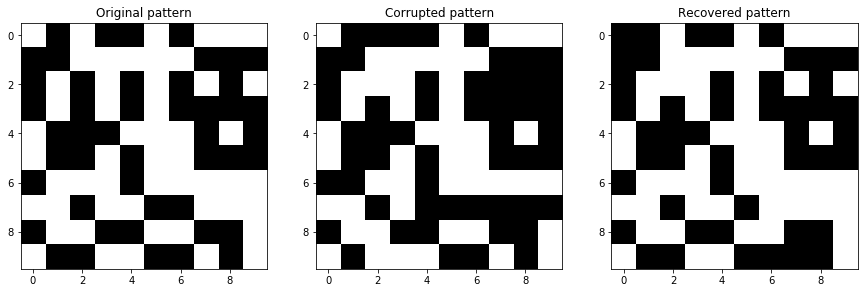

In [8]:
#Creates corrupted random data.
def corrupt_uniform(sys, q): #q is the threshold probability
    sys_temp = deepcopy(sys)
    N = sys.shape[0]
    for i in range(N):
        r = np.random.rand()
        if r < q:
            sys_temp[i] *= -1
    return sys_temp
    
#Testing the function
idx = 1
yi = corrupt_uniform(xi[idx],0.1) #we start with q = 0.1
wrong_pixels, assigned_pattern, sys =algorithm(xi, idx, yi)
print('The error of the algorithm is %f' %(wrong_pixels))
print('The algorithm recognised the pattern %i and the correct pattern is %i' %(assigned_pattern,idx))
plot(xi[idx], yi, sys)

# Varying the probability

In this section we change the values of the threshold probability $q$ in order to visualize how the system behaves using both MF and NMF.

In [ ]:
#set the probabilities between 0 and 1
probabilities = np.arange(0,1,0.05)
error = [[],[]]
sigma = [[],[]]

MF = [0,1]

for i in MF:
    if i: J = MF_coupling(xi,N)
    else: J = R_coupling(xi,N,R)        
    for q in probabilities:
        supp = []
        for n in range(100):
            yi = corrupt_uniform(xi[idx],q)
            wrong_pixels, assigned_pattern, sys = algorithm(xi, idx, yi)
            supp.append(wrong_pixels)
        supp = np.array(supp)
        error[i].append(supp.mean())
        sigma[i].append(supp.std())

#Plot the results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))

ax1.plot(probabilities, error[0], '--bo')
ax1.set_title('Dependence on the algorithm according to parameter $q$ with NO Mean Field')
ax1.set_xlabel('Uniform Probability $q$')
ax1.set_ylabel('Error')
ax1.errorbar(probabilities, error[0], yerr = sigma[0], fmt = "none")

ax2.plot(probabilities, error[1], '--bo')
ax2.set_title('Dependence on the algorithm according to parameter $q$ with Mean Field')
ax2.set_xlabel('Uniform Probability $q$')
ax2.set_ylabel('Error')
ax2.errorbar(probabilities, error[1], yerr = sigma[1], fmt = "none")        
        


<img src=".\Images\plot1.png">

From the graphs, we can deduced that with probabilty of about 20% the error remains constant in both cases, especially in the MF case. This implies that for this given probability the algorithm recover the pattern perfectly. As we expect, the error increase when more pixel are flipped. 

One can see that the NMF is less steep than the MF, but both have a sigmoid shape. 

By observing the errobars, one could notice that their behaviour is different for each interval of $q$:
- if $q\in (0, 0.2)$, the correct pattern is always recovered and so we have negligible errors;
- if $q\in (0.2, 0.8)$, since we change each pixel with $q \sim 0.5$, we start from different patterns and so we explore a wider range of patterns (minima of the system);
- if $q\in (0.8,1)$ almost all the pixels are flipped and so the algorithm recovers always the same pattern, even if it is wrong.

## Gaussian noise

The gaussian distribution is given by:
$$
\\
g(x) = h \cdot \exp{\left[{-\frac{(x-\mu)^2}{2\sigma^2}}\right]}
\\
$$
where $h$ is the maximum height of the distribution, $\mu$ is its mean and $\sigma$ its standard deviation.

A 2D gaussian, made by the product of two statistically independent gaussians distribution, is overlapped to the original pattern. The coordinates of the centroids were chosen so as to pick only the most relevant cases, i.e. the center of the grid and its four corners. An arbitrary value of $\sigma$ is chosen as $L/5$ in order to have a gaussian with a probability that goes to $0$ at the edges of the grid when the centroid is in its center. 

Concerning the parameter $h$, we decided not to choose the normalized version of the gaussian as it would have been unsignificant to our purpose, so we made $h$ vary between 0.1 and 1 in order to have different thresholds. To obtain the corrupted patterns, a random number $r$ is generated using $\textit{uniform distribution}$ for each pixel. If $r$ is less than the threshold, set by the value of the gaussian in the considered point, then the pixel is flipped. 

After corrupting the patterns, the deterministic Hopfield function is called in order to produce a $\textit{Recovered}$ one. Furthermore, the error with respect to the original pattern is calculated. 


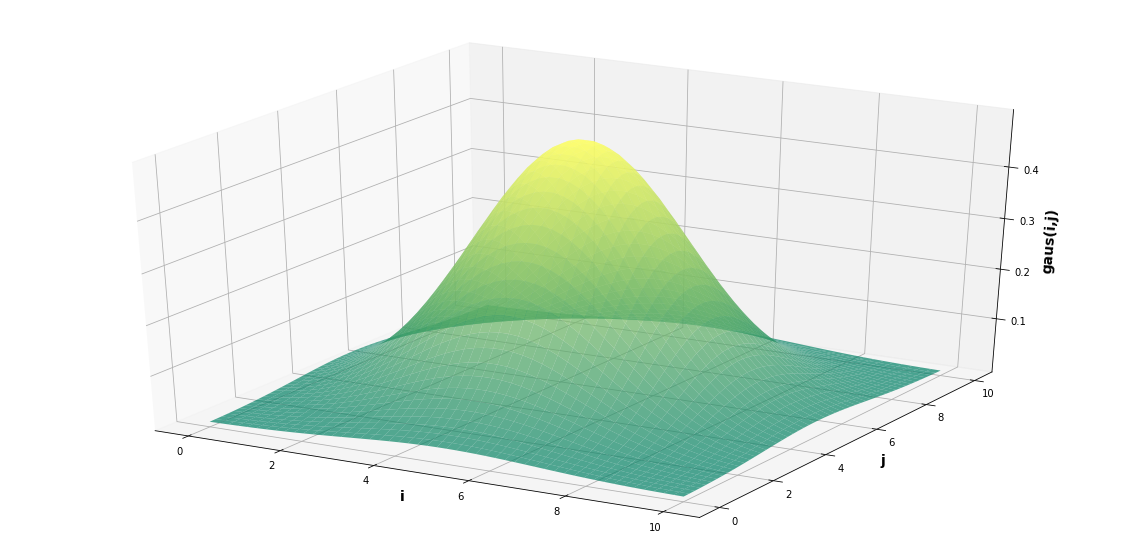

In [9]:
def gaus(mu, sigma, h, x, y): #mu is a 2d array representing the position of the centroid
                              #h is the maximum height of the gaussian
    h = np.sqrt(h)
    g_x = np.exp(-( (x-mu[0])**2 / ( 2.0 * sigma**2 ) ) )*h
    g_y = np.exp(-( (y-mu[1])**2 / ( 2.0 * sigma**2 ) ) )*h
    g = g_y * g_x
    return g

def gaus_3d(mu, sigma, h, x): #mu is a 2d array representing the position of the centroid
                              #h is the maximum height of the gaussian
    h = np.sqrt(h)
    g_x = np.exp(-( (x[0]-mu[0])**2 / ( 2.0 * sigma**2 ) ) )*h
    g_y = np.exp(-( (x[1]-mu[1])**2 / ( 2.0 * sigma**2 ) ) )*h
    g = g_y * g_x
    return g


x = np.linspace(0,10)
y = np.linspace(0,10)
X, Y = np.meshgrid(x, y)
Z = gaus_3d([5,5], 2, 0.5, [X, Y])

fig = plt.figure(figsize=(20, 10))
ax = fig.gca(projection='3d')
ax.plot_surface(X, Y, Z, cmap='summer', alpha=0.7)
ax.set_xlabel("i", fontweight='bold', fontsize=14)
ax.set_ylabel("j", fontweight='bold', fontsize=14)
ax.set_zlabel("gaus(i,j)", fontweight='bold', fontsize=14)            
pb.show()

In [ ]:
def corrupt_norm(sys, k, h): #k represent the mean in the gaussian
                             #h represent the height in the gaussian
    sys_temp = deepcopy(sys)
    sys_temp = sys_temp.reshape(L,L)
    N = sys.shape[0]
    for i in range(L):
        for j in range(L):
            g = gaus(k, L/5, h, i, j)
            r = np.random.rand()
            if r < g:
                sys_temp[i][j] *= -1
    return (sys_temp.reshape(1,N))[0]

idx = 1
centroids = [np.array([0,0]), np.array([0,L-1]), np.array([L-1,0]), np.array([L-1,L-1]), np.array([L//2, L//2])]
heights = np.linspace(0.1,1,10)

for k in centroids:
    print('The position of the centroid is ', k,'\n')
    for h in heights:
        print('The height of the distribution is ', h)
        yi = corrupt_norm(xi[idx], k, h)
        wrong_pixels, assigned_pattern, sys = algorithm(xi, idx, yi)
        print('The error of the algorithm is %f' %(wrong_pixels))
        print('The algorithm recognised the pattern %i and the correct pattern is %i' %(assigned_pattern,idx))
        plot(xi[idx], yi, sys)

<img src = ".\Images\gaus.jpeg">

The figure shows the original pattern, the corrupted one with the centroid of the gaussian in the middle (using $h = 1$) and the recovered one. 
It can be seen that the corrupted pattern flip some pixels in the middle as we expected. 

# Error as a function of gaussian's height

In this section, we compare the results using MF and NMF, studying the error of the algorithm as a function of the height $h$ of the gaussian.

In [ ]:
# parameters 
idx = 1
heights = np.linspace(0,1,10)
centroids = [np.array([0,0]), np.array([0,L-1]), np.array([L-1,0]), np.array([L-1,L-1]), np.array([L//2, L//2])]

In [ ]:
# gaussian corrupt error behaviour with non mean field changing the parameter height on the gaussian
MF = 0
error_NMF = [[],[], [],[], []]
sigma_NMF = [[],[], [],[], []]
i = 0

if MF: J = MF_coupling(xi,N)
else: J = R_coupling(xi,N,R)            

for k in centroids:
    for h in heights:
        supp = []
        for n in range(50):
            yi = corrupt_norm(xi[idx], k, h)
            wrong_pixels, assigned_pattern, sys = algorithm(xi, idx, yi)
            supp.append(wrong_pixels)
        supp = np.array(supp)
        error_NMF[i].append(supp.mean())
        sigma_NMF[i].append(supp.std())
    i +=1 


In [ ]:
# gaussian corrupt error behaviour with mean field changing the parameter height on the gaussian
MF = 1
error_MF = [[],[], [],[], []]
sigma_MF = [[],[], [],[], []]
i = 0

if MF: J = MF_coupling(xi,N)
else: J = R_coupling(xi,N,R)
        
for k in centroids:
    for h in heights:
        supp = []
        for n in range(50):
            yi = corrupt_norm(xi[idx], k, h)
            wrong_pixels, assigned_pattern, sys = algorithm(xi, idx, yi)
            supp.append(wrong_pixels)
        supp = np.array(supp)
        error_MF[i].append(supp.mean())
        sigma_MF[i].append(supp.std())
    i +=1  
    

In [ ]:
#plot the results
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 15))

ax1.plot(heights, error_NMF[0], '--bo', label ='Error behaviour in centroid [0,0]')
ax1.plot(heights, error_NMF[1], '-ro', label ='Error behaviour in centroid [0,L-1]')
ax1.plot(heights, error_NMF[2], '--go', label ='Error behaviour in centroid [L-1,0]')
ax1.plot(heights, error_NMF[3], '--yo', label ='Error behaviour in centroid [L-1,L-1]')
ax1.plot(heights, error_NMF[4], '--co', label ='Error behaviour in middle centroid')
ax1.set_title('Dependence on the algorithm according to height $h$ of the gaussian with NO Mean Field')
ax1.set_xlabel('Heights $h$')
ax1.set_ylabel('Error');
ax1.legend()


ax2.plot(heights, error_MF[0], '--b', label ='Error behaviour in centroid [0,0]')
ax2.plot(heights, error_MF[1], '--ro', label ='Error behaviour in centroid [0,L-1]')
ax2.plot(heights, error_MF[2], '--go', label ='Error behaviour in centroid [L-1,0]')
ax2.plot(heights, error_MF[3], '--yo', label ='Error behaviour in centroid [L-1,L-1]')
ax2.plot(heights, error_MF[4], '--co', label ='Error behaviour in middle centroid')
ax2.set_title('Dependence on the algorithm according to height $h$ of the gaussian with Mean Field')
ax2.set_xlabel('Heights $h$')
ax2.set_ylabel('Error');
ax2.legend()


<img src="./Images/gaussian_corruption_h.png">

The MF model is not influenced by the gaussian noise, as it is able to get a broad picture and not be mislead by local changes.

On the contrary, the NMF is affected, especially if the centroid coincide with the middle of the grid. The error increase with the gaussian height, as expected.

## Cauchy noise

The Cauchy distribution is given by:
$$
\\
\mathcal{C}(x) = h \cdot \left(1 + \left(\frac{x- x_0}{\gamma}\right)^2 \right)^{-1}
\\
$$
where $h$ is the maximum height of the distribution, $x_{0}$ specifies the location of the peak of the distribution, and $\gamma$ is the scale parameter which specifies the half-width at half-maximum (HWHM).

We chose $\gamma$ arbitrarily ($\gamma = L/5$) and made the peak $x_0$ of the distribution and its height $h$ variable, like the parameters $\sigma$ and $\mu$ of the gaussian distribution.

We followed the same approach we used for the gaussian noise: we overlapped a 2-dimensional Cauchy distribution, and we used it to have a variable threshold for each pixel. Then we generated corrupted patterns, recovered them and evaluated the error.


In [10]:
def cauchy(mu, gamma, h, x, y):#mu is a 2d array representing the position of the median
                               #h is the maximum height of the distribution     
    h = np.sqrt(h)
    c_x = h/(1 + (((x-mu[0]))/gamma)**2)
    c_y = h/(1 + (((y-mu[1]))/gamma)**2)
    c = c_y * c_x
    return c

In [ ]:
def corrupt_cauchy(sys, k, h): #k represent the mean in the cauchy distribution
                               #h represent the height in the cauchy distribution
    sys_temp = deepcopy(sys)
    sys_temp = sys_temp.reshape(L,L)
    N = sys.shape[0]
    for i in range(L):
        for j in range(L):
            g = cauchy(k, L/5, h, i, j)
            r = np.random.rand()
            if r < g:
                sys_temp[i][j] *= -1
    return (sys_temp.reshape(1,N))[0]

idx = 1
centroids = [np.array([0,0]), np.array([0,L-1]), np.array([L-1,0]), np.array([L-1,L-1]), np.array([L//2, L//2])]
heights = np.linspace(0.1,1,10)

for k in centroids:
    print('The position of the median is ', k,'\n')
    for h in heights:
        print('The height of the distribution is ', h)
        yi = corrupt_cauchy(xi[idx], k, h)
        wrong_pixels, assigned_pattern, sys = algorithm(xi, idx, yi)
        print('The error of the algorithm is %f' %(wrong_pixels))
        print('The algorithm recognised the pattern %i and the correct pattern is %i' %(assigned_pattern,idx))
        plot(xi[idx], yi, sys)
        

<img src = ".\Images\corrupted_cauchy.png">

The figure shows the original pattern, the corrupted one with the centroid of the cauchy in the middle of the grid (using $h = 1$) and the recovered one. 

As we expected, the flipped pixel are mostly in the middle, following the tendency of the Cauchy distribution, which is more spread than the gaussian one.


# Error as a function of Cauchy curve's height

In this section, we compare the results using MF and NMF, studying the error of the algorithm as a function of the height $h$ of the Cauchy distribution.

In [ ]:
# Behaviour of Cauchy distribution changing height using MF
MF = 1
error_MF_cauchy = [[],[], [],[], []]
i = 0

if MF: J = MF_coupling(xi,N)
else: J = R_coupling(xi,N,R)
            
for k in centroids:
    for h in heights:
        supp = []
        for n in range(50):
            yi = corrupt_cauchy(xi[idx], k, h)
            wrong_pixels, assigned_pattern, sys = algorithm(xi, idx, yi)
            supp.append(wrong_pixels)
        supp = np.array(supp)
        error_MF_cauchy[i].append(supp.mean())
    i +=1 
      

In [ ]:
# Behaviour of Cauchy distribution changing height using NMF
MF = 0
error_NMF_cauchy = [[],[], [],[], []]
i = 0

if MF: J = MF_coupling(xi,N)
else: J = R_coupling(xi,N,R)
            
for k in centroids:
    for h in heights:
        supp = []
        for n in range(50):
            yi = corrupt_cauchy(xi[idx], k, h)
            wrong_pixels, assigned_pattern, sys = algorithm(xi, idx, yi)
            supp.append(wrong_pixels)
        supp = np.array(supp)
        error_NMF_cauchy[i].append(supp.mean())
    i +=1 
       

In [ ]:
#plot the results
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 15))

ax1.plot(heights, error_NMF_cauchy[0], '--bo', label ='Error behaviour in centroid [0,0]')
ax1.plot(heights, error_NMF_cauchy[1], '--ro', label ='Error behaviour in centroid [0,L-1]')
ax1.plot(heights, error_NMF_cauchy[2], '--go', label ='Error behaviour in centroid [L-1,0]')
ax1.plot(heights, error_NMF_cauchy[3], '--yo', label ='Error behaviour in centroid [L-1,L-1]')
ax1.plot(heights, error_NMF_cauchy[4], '--co', label ='Error behaviour in middle centroid')
ax1.set_title('Dependence on the algorithm according to height $h$ of the cauchy with NO Mean Field')
ax1.set_xlabel('Heights $h$')
ax1.set_ylabel('Error');
ax1.legend()


ax2.plot(heights, error_MF_cauchy[0], '--bo', label ='Error behaviour in centroid [0,0]')
ax2.plot(heights, error_MF_cauchy[1], '--ro', label ='Error behaviour in centroid [0,L-1]')
ax2.plot(heights, error_MF_cauchy[2], '--go', label ='Error behaviour in centroid [L-1,0]')
ax2.plot(heights, error_MF_cauchy[3], '--yo', label ='Error behaviour in centroid [L-1,L-1]')
ax2.plot(heights, error_MF_cauchy[4], '--co', label ='Error behaviour in middle centroid')
ax2.set_title('Dependence on the algorithm according to height $h$ of the cauchy with Mean Field')
ax2.set_xlabel('Heights $h$')
ax2.set_ylabel('Error');
ax2.legend()

<img src="./Images/cauchy_corruption_h.png">

Again, just like the gaussian case, the MF model is not influenced by the Cauchy noise, as it is able to get a broad picture and not be mislead by local changes.

On the contrary, the NMF is even more affected, especially if the centroid coincide with the middle of the grid. The Caushy distribution is indeed wider and hence impacts on more pixels than the gaussian. Anyway, the error increase with the Cauchy curve height, as expected.

# Montecarlo simulation

Montecarlo simulations are computational tools that use pseudorandom numbers to feign the evolution of a physical system. As we have stated before, a really interesting feature of the Hopfield model is that it gives us the possibility of mapping a neuron system into a spin glasses system, hence giving us the possibility to employ such techniques. 

For this particular task we aim at finding the ground state of a spin system using the Metropolis algorithm as update rule. 

Given the system energy $\mathcal{H}$, we randomly flip a spin of the system and we compute the difference in energy $\Delta\mathcal{H}=\mathcal{H}_{f}-\mathcal{H}_{i}$. Then accept the updated system with the following probability:
$$
\begin{equation}
p_{acc}= \min\left( 1, e^{-\beta\Delta\mathcal{H}} \right)
\end{equation}
$$
where $\beta=(K_{b}T)^{-1}$ is the inverse of the temperature of the system. In this way if the energy is decreasing, we update the system with probability 1, while if it is greater, with a probability inversely proportional to the increase in energy.
From the theory we know that the critical temperature, i.e. the highest temperature at which the system is trapped in a minimum, is $T=1/K_b$, hence $\beta=1$.

In this section we will cover:

- the stability of the Montecarlo methods;
- the improvement in the time implementation of Montecarlo;
- the dependance of the algorithm's performances w.r.t. the type of noise;
- the dependance of the algorithm's performances w.r.t. the number of neighbors for the NMF version;
- the distinguish criteria between similar patterns.


In [11]:
def H(J,sys):  #energy of the system
    N = sys.shape[0]
    energy = 0
    for i in range(N):
        for j in range(i):
            energy -= J[i][j]*sys[i]*sys[j]
    return energy

# difference if energy when flipping the spin k
def dH(J, sys, k): 
    N = sys.shape[0]
    dh = 0
    for i in range(N):
        dh += sys[i]*J[k][i]
    dh *= 2*sys[k]
    return dh

#metropolis update rule
def metropolis(J, sys1, k, B): # B = 1/kbT temperature of the system
    sys = deepcopy(sys1)
    dh = dH(J, sys, k)
    r = np.random.rand() # random variable between (0,1)
    if r < np.exp( -B*dh ):
        sys[k] = -sys[k]
    return sys

#actual algorithm
def montecarlo(J, sys1, B, t ): # t number of iteration of the montecarlo
    sys = deepcopy(sys1)
    N = sys.shape[0]
    for i in range(t):
        k = np.random.randint(0,N)
        sys = metropolis(J, sys, k, B)
    return sys

## Stability for Mean Field Montecarlo method

In this section, we study the stability of the Montecarlo method w.r.t. its characteristical parameters: $\beta$, $t$ number of iterations.
To underline how the model loses significance if $p \geq \sqrt{N}$, we will display the results for both $p=5$ and $p=10$ for a system of size $N=100$.

In [12]:
xi = random_patterns(N,p)
J = MF_coupling(xi,N)

The error of the algorithm is 0.000000
The algorithm recognised the pattern 2 and the correct pattern is 2


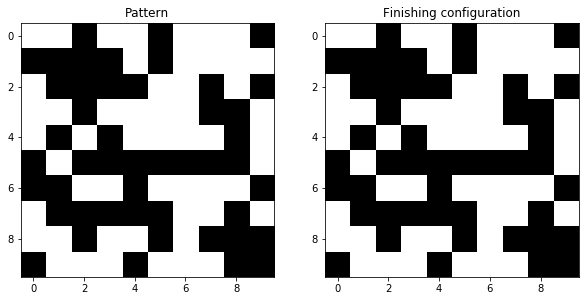

In [13]:
idx = np.random.randint(10)

sys = montecarlo(J,xi[idx], 10, 1000)
wrong_pixels = error_im(xi[idx],sys)
assigned_pattern = assign_pattern(xi,sys)


fig, ax = plt.subplots(1,2, figsize = (10,6))
ax[0].set_title('Pattern')
ax[0].imshow(xi[idx].reshape(L,L), cmap='Greys')
ax[1].set_title('Finishing configuration')
ax[1].imshow(sys.reshape(L,L), cmap='Greys')
print('The error of the algorithm is %f' %(wrong_pixels))
print('The algorithm recognised the pattern %i and the correct pattern is %i' %(assigned_pattern,idx))

### Temperature analysis

We fix the number of iterations to $t=1000$ and size of the system to $N=100$ ($L=10$), while changing the temperature in a range $\beta=[0,1,10,25,50,100]$. For each point we consider the average over $100$ loops.

In [ ]:
beta = [0, 1, 10, 25, 50, 100]
err_beta_mean = []
err_beta_std = []
success = []
for b in beta:
    errors = []
    correct = 0
    for j in range(100):
        idx = np.random.randint(10)
        sys = montecarlo(J,xi[idx], b, 1000)
        wrong_pixels = error_im(xi[idx],sys)
        assigned_pattern = assign_pattern(xi,sys)

        if idx == assigned_pattern: correct += 1
        errors.append(wrong_pixels) 
        
    correct /= 100
    errors = np.array(errors)
    err_beta_mean.append( errors.mean() )
    err_beta_std.append( errors.std() )
    success.append(correct)
    
fig, ax = plt.subplots(1,2,figsize=(12,6))

ax[0].set_title('Errors as function of T')
ax[0].set_xlabel('Beta [$J^{-1}$]')
ax[0].set_ylabel('Average error')
ax[0].plot(beta, err_beta_mean, '--bo', label='Error')
ax[0].errorbar(beta,err_beta_mean, yerr=err_beta_std,ecolor='red', label='Fluctuation of error',fmt='none')
ax[0].legend()

ax[1].set_title('Probability of success as function of T')
ax[1].set_xlabel('Beta [$J^{-1}$]')
ax[1].set_ylabel('Probability of success')
ax[1].plot(beta, success, '--ro', label='Data')
ax[1].legend()

$p=5$

<img src = ".\Images\temperature_MFM.png">

$p=10$

<img src = ".\Images\m_avge_beta.png">

We can see how a higher value of $\beta$ leads to  higher probability of success, and a $\beta<10$ leads to totally unacceptable results.

Even if $\beta>25$ seems to produce better results, we have to think about the functioning of the algorithm: with a very high beta, the probability of flipping a "wrong" spin is $\sim0$ and, starting from a minimum, it probably means that it does not flip a spin at all. So, for the following analisys we will use $\beta=10$.

In this analysis we don't see big differences given by the number of patterns.

### Number of iteration analysis

Here we analyze the stability of the algorithm w.r.t. the number of iterations, chosen in a range $t=[10,25,50,100,200,500,750,1000,1250,1500,1750,2000]$, while the other parameters are kept fixed ($\beta=[10,25]$ and $L=10$). For each point we consider the average over $100$ loops.

In [ ]:
iterations=[10,25,50,100,200,500,750,1000,1250,1500,1750,2000]

# Beta = 10
err_t_mean = []
err_t_std = []
success_t = []
for t in iterations:
    errors = []
    correct = 0
    for j in range(100):
        idx = np.random.randint(10)
        sys = montecarlo(J,xi[idx], 10, t)
        wrong_pixels = error_im(xi[idx],sys)
        assigned_pattern = assign_pattern(xi,sys)

        if idx == assigned_pattern: correct += 1
        errors.append(wrong_pixels) 
        
    correct /= 100
    errors = np.array(errors)
    err_t_mean.append( errors.mean() )
    err_t_std.append( errors.std() )
    success_t.append(correct)
    
# Beta = 25
err_t1_mean = []
err_t1_std = []
success_t1 = []
for t in iterations:
    errors = []
    correct = 0
    for j in range(100):
        idx = np.random.randint(10)
        sys = montecarlo(J,xi[idx], 25, t)
        wrong_pixels = error_im(xi[idx],sys)
        assigned_pattern = assign_pattern(xi,sys)

        if idx == assigned_pattern: correct += 1
        errors.append(wrong_pixels) 
        
    correct /= 100
    errors = np.array(errors)
    err_t1_mean.append( errors.mean() )
    err_t1_std.append( errors.std() )
    success_t1.append(correct)

fig, ax = plt.subplots(1,2,figsize=(12,6))

ax[0].set_title('Errors as function of iterations')
ax[0].set_xlabel('Number of iteration t')
ax[0].set_ylabel('Average error')
ax[0].plot(iterations, err_t_mean, '--bo', label='Error with beta=10')
ax[0].errorbar(iterations,err_t_mean, yerr=err_t_std,ecolor='blue',fmt='none')
ax[0].plot(iterations, err_t1_mean, '--go', label='Error with beta=25')
ax[0].errorbar(iterations,err_t1_mean, yerr=err_t1_std,ecolor='green',fmt='none')
ax[0].legend()

ax[1].set_title('Probability of success as function of the number of iterations t')
ax[1].set_xlabel('Number of iteration t')
ax[1].set_ylabel('Probability of success')
ax[1].plot(iterations, success_t, '--bo', label='Data with beta=10')
ax[1].plot(iterations, success_t1, '--go', label='Data with beta=25')
ax[1].legend()

$p=5$

<img src = ".\Images\iterationsMFM.png">

$p=10$

<img src = ".\Images\m_s_iterations.png">

Here the number of patterns influence in a huge way the results. We can see that, as we can expect, with $p=5$ the algorithm reaches convergence from the start. Instead, with $p=10$, increasing the number of iterations raises the error. We can expect this sort of behaviour, since there are too much patterns and the minima are not clearly distincted.

In the $p=10$ graph we can observe  that a $\beta=10$ leads to a unstable situation: in fact, the error reaches a plateau, but not the probability of success.
On the other hand, with $\beta=25$, both error and probability of success seems to reach a plateau. So in the following we will use $25$ as the value of $\beta$.

Given these results, we decide to set the optimal $t$ as the beginning of the plateau, namely $t=1000$, since for that value even the difficoult problem of classify too many patterns reaches a convergence.

## Corruption with uniform noise

As the stability of the algorithm has been thoroughly studied, we proceed to corrupt and recover patterns, starting from a uniform distribution along the grid of height $q$.

We only used this kind of noise because it was the most significant one.

The error of the algorithm is 0.060000
The algorithm recognised the pattern 3 and the correct pattern is 3


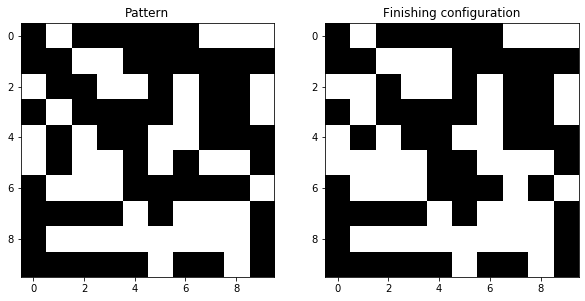

In [14]:
idx = 3

yi = corrupt_uniform(xi[idx], 0.2)

sys = montecarlo(J,yi, 10, 100)
wrong_pixels = error_im(xi[idx],sys)
assigned_pattern = assign_pattern(xi,sys)


fig, ax = plt.subplots(1,2, figsize = (10,6))
ax[0].set_title('Pattern')
ax[0].imshow(xi[idx].reshape(L,L), cmap='Greys')
ax[1].set_title('Finishing configuration')
ax[1].imshow(sys.reshape(L,L), cmap='Greys')
print('The error of the algorithm is %f' %(wrong_pixels))
print('The algorithm recognised the pattern %i and the correct pattern is %i' %(assigned_pattern,idx))

### Temperature analysis

First of all, it is needed to be stated that in this section we start from a corrupted pattern. This observation seems trivial, but indeed it is not, because the starting configuration is not a minimum and as a consequence some iterations are required to reach one of the original patterns.

Hence, we study the dependance of the algorithm on the temperature, with uniformly corrupted patterns using $q=0.2$.

In [ ]:
beta = [0, 1, 10, 25, 50, 100]
err_beta_mean_c = []
err_beta_std_c = []
success_beta_c = []

for b in beta:
    errors = []
    correct = 0
    for j in range(100):
        idx = np.random.randint(10)
        yi = corrupt_uniform(xi[idx], 0.2)
        sys = montecarlo(J, yi, b, 1000)
        wrong_pixels = error_im(xi[idx],sys)
        assigned_pattern = assign_pattern(xi,sys)

        if idx == assigned_pattern: correct += 1
        errors.append(wrong_pixels) 
        
    correct /= 100
    errors = np.array(errors)
    err_beta_mean_c.append( errors.mean() )
    err_beta_std_c.append( errors.std() )
    success_beta_c.append(correct)

fig, ax = plt.subplots(1,2,figsize=(12,6))

ax[0].set_title('Errors as function of T with uniform noise')
ax[0].set_xlabel('Beta [$J^{-1}$]')
ax[0].set_ylabel('Average error')
ax[0].plot(beta, err_beta_mean_c, '--bo', label='Error')
ax[0].errorbar(beta,err_beta_mean_c, yerr=err_beta_std_c,ecolor='red', label='Fluctuation of error',fmt='none')
ax[0].legend()

ax[1].set_title('Probability of success as function of T with uniform noise')
ax[1].set_xlabel('Beta [$J^{-1}$]')
ax[1].set_ylabel('Probability of success')
ax[1].plot(beta, success_beta_c, '--ro', label='Data')
ax[1].legend()

<img src = ".\Images\Temp_MFM_C.png">

Observing these graphs, a further confirmation of the best choice for the temeperature parameter $\beta$ can be found, just as stated in the stability section. 

Consequently, from now on we will use $\beta = 25$.

### Number of iteration analysis

Just as the previously, we analyze the performances of the algorithm w.r.t. the number of iterations, chosen in a range $t=[10,25,50,100,200,500,750,1000,1250,1500,1750,2000]$, while the other parameters are kept fixed ($\beta=25$, $L=10$, $q=0.2$). For each point we consider the average over $100$ loops.

In [ ]:
iterations = [10,25,50,100,200,500,750,1000,1250,1500,1750,2000]
err_t_mean_c = []
err_t_std_c = []
success_t_c = []

for t in iterations:
    errors = []
    correct = 0
    for j in range(100):
        idx = np.random.randint(10)
        yi = corrupt_uniform(xi[idx], 0.2)
        sys = montecarlo(J, yi, 25, t)
        wrong_pixels = error_im(xi[idx],sys)
        assigned_pattern = assign_pattern(xi,sys)

        if idx == assigned_pattern: correct += 1
        errors.append(wrong_pixels) 
        
    correct /= 100
    errors = np.array(errors)
    err_t_mean_c.append( errors.mean() )
    err_t_std_c.append( errors.std() )
    success_t_c.append(correct)
    
    
fig, ax = plt.subplots(1,2,figsize=(12,6))

ax[0].set_title('Errors as function of iterations')
ax[0].set_xlabel('Number of iteration t')
ax[0].set_ylabel('Average error')
ax[0].plot(iterations, err_t_mean_c, '--bo', label='Errors')
ax[0].errorbar(iterations,err_t_mean_c, yerr=err_t_std_c, ecolor='blue',fmt='none')
ax[0].legend()

ax[1].set_title('Probability of success as function of the number of iterations t')
ax[1].set_xlabel('Number of iteration t')
ax[1].set_ylabel('Probability of success')
ax[1].plot(iterations, success_t_c, '--bo', label='Data')
ax[1].legend()

<img src=".\Images\Iter_MFM_C.png">

It is difficult to outline a clear trend in both graphs. Probably, increasing the number of tests and observations could lead to better results. 
In any case, the graphs seem to reach an oscillatory behaviour after $t=1000$, this is particularly evident by observing the tendency of the probability of success. 

For this reason we choose $t=500$.


### Varying the probability $q$ 

Last but not least, we analyse the behaviour of the algorithm with $t=500$, $\beta=25$, changing the value of  $q \in [0.1,1]$ in steps of $0.1$.

In [ ]:
prob = np.linspace(0,1,10)
err_q_mean_c = []
err_q_std_c = []
success_q_c = []

for q in prob:
    errors = []
    correct = 0
    for j in range(100):
        idx = np.random.randint(10)
        yi = corrupt_uniform(xi[idx], q)
        sys = montecarlo(J, yi, 25, 500)
        wrong_pixels = error_im(xi[idx],sys)
        assigned_pattern = assign_pattern(xi,sys)

        if idx == assigned_pattern: correct += 1
        errors.append(wrong_pixels) 
        
    correct /= 100
    errors = np.array(errors)
    err_q_mean_c.append( errors.mean() )
    err_q_std_c.append( errors.std() )
    success_q_c.append(correct)
    
fig, ax = plt.subplots(1,2,figsize=(12,6))

ax[0].set_title('Errors as function of the flipping probability')
ax[0].set_xlabel('Flipping probability q')
ax[0].set_ylabel('Average error')
ax[0].plot(prob, err_q_mean_c, '--bo', label='Errors')
ax[0].errorbar(prob,err_q_mean_c, yerr=err_q_std_c, ecolor='blue',fmt='none')
ax[0].legend()

ax[1].set_title('Probability of success as function of the flipping probabiity')
ax[1].set_xlabel('Flipping probability q')
ax[1].set_ylabel('Probability of success')
ax[1].plot(prob, success_q_c, '--bo', label='Data')
ax[1].legend()

<img src=".\Images\prob_MF_C.png">

We clearly see that, even if the error is still acceptable, the maximum value of the noise that we can accept to have good performances is $q=0.2$.

# Non Mean Field Montecarlo

Up to now we used only the MF version, where all the spins interacts with each other. We will now use a version of the algorithm where the spins interacts only within a small range, indicated with $R$. <br>
We will not repeat the analysis of the dependance on temperature, and so we will use $\beta=25$.

The error of the algorithm is 0.030000
The algorithm recognised the pattern 3 and the correct pattern is 3


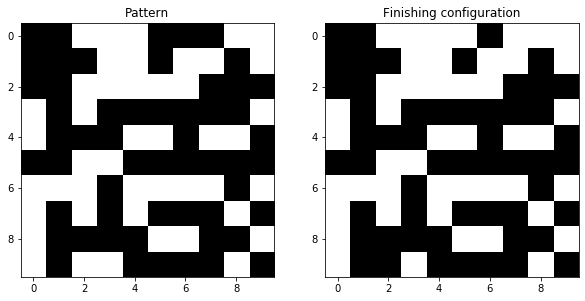

In [15]:
xi = random_patterns(N,p)
J = R_coupling(xi,N,3)

idx = 3

sys = montecarlo(J,xi[idx], 25, 1000)
wrong_pixels = error_im(xi[idx],sys)
assigned_pattern = assign_pattern(xi,sys)


fig, ax = plt.subplots(1,2, figsize = (10,6))
ax[0].set_title('Pattern')
ax[0].imshow(xi[idx].reshape(L,L), cmap='Greys')
ax[1].set_title('Finishing configuration')
ax[1].imshow(sys.reshape(L,L), cmap='Greys')
print('The error of the algorithm is %f' %(wrong_pixels))
print('The algorithm recognised the pattern %i and the correct pattern is %i' %(assigned_pattern,idx))

## Stability for the Non Mean Field Montecarlo

In this section we study the stability of the algorithm as a function of the number of neighbors, $R = [1,2,3,4,5]$ and two different number of iterations, $t=[500,1000]$.

In [ ]:
R = [1, 2, 3, 4, 5]
err_r_mean_c = []
err_r_std_c = []
success_r_c = []

for r in R:
    J = R_coupling(xi,N,r)
    errors = []
    correct = 0
    for j in range(100):
        idx = np.random.randint(10)
        sys = montecarlo(J, xi[idx], 25, 500)
        wrong_pixels = error_im(xi[idx],sys)
        assigned_pattern = assign_pattern(xi,sys)

        if idx == assigned_pattern: correct += 1
        errors.append(wrong_pixels) 
        
    correct /= 100
    errors = np.array(errors)
    err_r_mean_c.append( errors.mean() )
    err_r_std_c.append( errors.std() )
    success_r_c.append(correct)
    
err_r1_mean_c = []
err_r1_std_c = []
success_r1_c = []

for r in R:
    J = R_coupling(xi,N,r)
    errors = []
    correct = 0
    for j in range(100):
        idx = np.random.randint(10)
        sys = montecarlo(J, xi[idx], 25, 1000)
        wrong_pixels = error_im(xi[idx],sys)
        assigned_pattern = assign_pattern(xi,sys)

        if idx == assigned_pattern: correct += 1
        errors.append(wrong_pixels) 
        
    correct /= 100
    errors = np.array(errors)
    err_r1_mean_c.append( errors.mean() )
    err_r1_std_c.append( errors.std() )
    success_r1_c.append(correct)
    
fig, ax = plt.subplots(1,2,figsize=(12,6))

ax[0].set_title('Errors as function of nearest neighbors')
ax[0].set_xlabel('Number of nearest neighbors R')
ax[0].set_ylabel('Average error')
ax[0].plot(R, err_r_mean_c, '--bo', label='Error with t=500')
ax[0].errorbar(R,err_r_mean_c, yerr=err_r_std_c,ecolor='blue',fmt='none')
ax[0].plot(R, err_r1_mean_c, '--go', label='Error with t=1000')
ax[0].errorbar(R,err_r1_mean_c, yerr=err_r1_std_c,ecolor='green',fmt='none')
ax[0].legend()

ax[1].set_title('Probability of success as function of nearest neighbors')
ax[1].set_xlabel('Number of nearest neighbors R')
ax[1].set_ylabel('Probability of success')
ax[1].plot(R, success_r_c, '--bo', label='Data with t=500')
ax[1].plot(R, success_r1_c, '--go', label='Data with t=1000')
ax[1].legend()

<img src=".\Images\NN_NMFM.png">

As expected, increasing the number of nearest neighbors enhances the performances of the algorithm, and makes the NMF model approach to the MF one.

Actually, the error and the probability of success with $R=5$ are even better than the ones obtained thanks to the MF model. Another important thing to notice is that the algorithm for different $t$ converges to the same value.

## Corruption with noise

We will see now how the noise affect the performances of the NMF Montecarlo method. This analysis is very interesting because we will see different behaviour between gaussian and uniform noise.

### Uniform noise

Here we analyse how different threshold probabilities $q$ affect the performances, with $\beta=25$, $R=[3,5]$ and $t=1000$.

The error of the algorithm is 0.030000
The algorithm recognised the pattern 3 and the correct pattern is 3


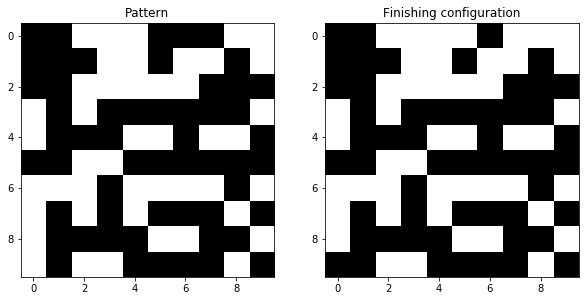

In [16]:
idx = 3
yi = corrupt_uniform(xi[idx], 0.2)

sys = montecarlo(J,yi, 25, 1000)

wrong_pixels = error_im(xi[idx],sys)
assigned_pattern = assign_pattern(xi,sys)

fig, ax = plt.subplots(1,2, figsize = (10,6))
ax[0].set_title('Pattern')
ax[0].imshow(xi[idx].reshape(L,L), cmap='Greys')
ax[1].set_title('Finishing configuration')
ax[1].imshow(sys.reshape(L,L), cmap='Greys')
print('The error of the algorithm is %f' %(wrong_pixels))
print('The algorithm recognised the pattern %i and the correct pattern is %i' %(assigned_pattern,idx))

In [ ]:
xi = random_patterns(N,p)
prob = np.linspace(0,1,10)
err_rq_mean_c = []
err_rq_std_c = []
success_rq_c = []

# R = 3
for q in prob:
    J = R_coupling(xi,N,3)
    errors = []
    correct = 0
    for j in range(100):
        idx = np.random.randint(10)
        yi = corrupt_uniform(xi[idx], q)
        sys = montecarlo(J, yi, 25, 1000)
        wrong_pixels = error_im(xi[idx],sys)
        assigned_pattern = assign_pattern(xi,sys)

        if idx == assigned_pattern: correct += 1
        errors.append(wrong_pixels) 
        
    correct /= 100
    errors = np.array(errors)
    err_rq_mean_c.append( errors.mean() )
    err_rq_std_c.append( errors.std() )
    success_rq_c.append(correct)
    
err_rq1_mean_c = []
err_rq1_std_c = []
success_rq1_c = []

# R = 5
for q in prob:
    J = R_coupling(xi,N,5)
    errors = []
    correct = 0
    for j in range(100):
        idx = np.random.randint(10)
        yi = corrupt_uniform(xi[idx], q)
        sys = montecarlo(J, yi, 25, 1000)
        wrong_pixels = error_im(xi[idx],sys)
        assigned_pattern = assign_pattern(xi,sys)

        if idx == assigned_pattern: correct += 1
        errors.append(wrong_pixels) 
        
    correct /= 100
    errors = np.array(errors)
    err_rq1_mean_c.append( errors.mean() )
    err_rq1_std_c.append( errors.std() )
    success_rq1_c.append(correct)
    
fig, ax = plt.subplots(1,2,figsize=(12,6))

ax[0].set_title('Errors as function of flipping probability')
ax[0].set_xlabel('Flipping probability q')
ax[0].set_ylabel('Average error')
ax[0].plot(prob, err_rq_mean_c, '--bo', label='Error with R=3')
ax[0].errorbar(prob,err_rq_mean_c, yerr=err_rq_std_c,ecolor='blue',fmt='none')
ax[0].plot(prob, err_rq1_mean_c, '--go', label='Error with R=5')
ax[0].errorbar(prob,err_rq1_mean_c, yerr=err_rq1_std_c,ecolor='green',fmt='none')
ax[0].legend()

ax[1].set_title('Probability of success as function of flipping probability')
ax[1].set_xlabel('Flipping probability q')
ax[1].set_ylabel('Probability of success')
ax[1].plot(prob, success_rq_c, '--bo', label='Data with R=3')
ax[1].plot(prob, success_rq1_c, '--go', label='Data with R=5')
ax[1].legend()

<img src=".\Images\prob_NMFM_C.png">

The behaviour outlined in the graphs is similar to the one of the MF, especially with the bigger number of neighbors ($R=5$).


### Gaussian noise

We corrupted the original patterns with a gaussian distribution; in this section we use $h\in[0,1]$ with steps of $0.1$ as gaussian heights, and the different centroid positions (corner or center of the grid).

We study the behaviour of the corrupted system with $\beta=25$, $R=5$. 

In [ ]:
xi = random_patterns(N,p)
heights = np.linspace(0,1,10)
err_rh_mean_c = []
err_rh_std_c = []
success_rh_c = []

for h in heights:
    J = R_coupling(xi,N,5)
    errors = []
    correct = 0
    for j in range(100):
        idx = np.random.randint(10)
        yi = corrupt_norm(xi[idx], np.array([0,0]), h)
        sys = montecarlo(J, yi, 25, 1000)
        wrong_pixels = error_im(xi[idx],sys)
        assigned_pattern = assign_pattern(xi,sys)

        if idx == assigned_pattern: correct += 1
        errors.append(wrong_pixels) 
        
    correct /= 100
    errors = np.array(errors)
    err_rh_mean_c.append( errors.mean() )
    err_rh_std_c.append( errors.std() )
    success_rh_c.append(correct)
    
err_rh1_mean_c = []
err_rh1_std_c = []
success_rh1_c = []
for h in heights:
    J = R_coupling(xi,N,5)
    errors = []
    correct = 0
    for j in range(100):
        idx = np.random.randint(10)
        yi = corrupt_norm(xi[idx], np.array([L//2, L//2]), h)
        sys = montecarlo(J, yi, 25, 1000)
        wrong_pixels = error_im(xi[idx],sys)
        assigned_pattern = assign_pattern(xi,sys)

        if idx == assigned_pattern: correct += 1
        errors.append(wrong_pixels) 
        
    correct /= 100
    errors = np.array(errors)
    err_rh1_mean_c.append( errors.mean() )
    err_rh1_std_c.append( errors.std() )
    success_rh1_c.append(correct)

fig, ax = plt.subplots(1,2,figsize=(12,6))

ax[0].set_title('Errors as function of the height of the gaussian')
ax[0].set_xlabel('Gaussian height h')
ax[0].set_ylabel('Average error')
ax[0].plot(heights, err_rh_mean_c, '--bo', label='Error with centroid in [0,0]')
ax[0].errorbar(heights,err_rh_mean_c, yerr=err_rh_std_c,ecolor='blue',fmt='none')
ax[0].plot(heights, err_rh1_mean_c, '--go', label='Error with centroid in [L/2,L/2]')
ax[0].errorbar(heights,err_rh1_mean_c, yerr=err_rh1_std_c,ecolor='green',fmt='none')
ax[0].legend()

ax[1].set_title('Probability of success as function of the height of the gaussian')
ax[1].set_xlabel('Gaussian height h')
ax[1].set_ylabel('Probability of success')
ax[1].plot(heights, success_rh_c, '--bo', label='Data with centroid in [0,0]')
ax[1].plot(heights, success_rh1_c, '--go', label='Data with centroid in [L/2,L/2]')
ax[1].legend()

<img src=".\Images\gauss_MNMF_C.png">

The probability of success decrease with the increase of the height of the gaussian if the centroid is in the middle of the grid: despite this, there is still a 60% of probability of recognising the correct pattern even in the worst case scenario ($h=1$).

On the other hand, the gaussian height does not affect too much the performance of the algorithm if the distribution is centered in one of the corners. 



## Time analisys

The aim of this section is to quantify the time implementation of the Montecarlo methods, both MF and not MF, in function of the size of the system N.

In [ ]:
lenght = np.array([5, 10, 15, 20, 25, 28, 30])
size = lenght**2
time_n_mean = []
time_n_std = []
for n in size:
    xi = random_patterns(n,p)
    J =  MF_coupling(xi,n)
    time1 = []
    for j in range(50):
        start = time.time()
        idx = np.random.randint(10)
        sys = montecarlo(J, xi[idx], 25, 1000)
        end = time.time()
        time1.append(end-start)
        
    time1 = np.array(time1)
    time_n_mean.append( time1.mean() )
    time_n_std.append( time1.std() )

fig, ax = plt.subplots(figsize=(12,6))

ax.set_title('Time implementation as function of the size of the system')
ax.set_xlabel('Size of the system L')
ax.set_ylabel('Average time implementation')
ax.plot(lenght, time_n_mean, '--bo', label='Montecarlo')
ax.errorbar(lenght,time_n_mean, yerr=time_n_std,ecolor='blue',fmt='none')
ax.plot(np.arange(10,28,4), times[0], '--ro', label='Deterministic Hopfield')
ax.legend()

times

<img src=".\Images\m_time.png">

Comparing the deterministic model and the Montecarlo one, we can see that the time implementation is way more efficient than the deterministic one, as we expected.

## Distinguish criteria of similar patterns

Finally, after discussing the performances and the advantages of the Hopfield model, we try to understand its limits.
Therefore, in this section we will study when and why the algorithm cannot distinguish some kind of patterns.

We define a set of $\textit{p similar patterns}$ as a group of $p$ patterns which cannot be distinguished by the Hopfield model.

Our first guess is that the similarity between two patterns is inversely proportional to the distance among the nearest different pixels.
Hence, we define a new function, $w_{sim}$, based on this hypothesis, and try to implement the model on the two most similar patterns so defined: a chessboard configuration.

In [17]:
# we work with this parameters 
L = 10
N = L**2

In [18]:
def w_sim(sys11, sys22, alpha): 
    sys1 = deepcopy(sys11)
    sys2 = deepcopy(sys22)
    N = sys1.shape[0]
    L = int(np.sqrt(N))
    sys1 = sys1.reshape(L,L)
    sys2 = sys2.reshape(L,L)
    wrong1 = [] #wrong black pixels in sys1
    wrong2 = [] # in sys2
    min_dist = [] 
    for i in range(L):
        for j in range(L):
            if sys1[i][j] == sys2[i][j]: continue
            elif sys1[i][j]== 1 : # if black in sys1
                wrong1.append( np.array([i,j]) )
            elif sys2[i][j]== 1: # if black in sys2
                wrong2.append( np.array([i,j]) )
    # compute distances between wrong pixels of the two systems
    for i in wrong1:
        distances = []
        for j in wrong2:
            if np.linalg.norm(i-j) !=0 :
                distances.append( np.linalg.norm(i-j) )
        min_dist.append( np.array(distances).min() )
    min_dist = np.array(min_dist)
    err =  (1/(min_dist)**alpha).sum()
    err = err/((N+1)//2) #normalization due to worst case scenario (a chessboard with more black cells)
    return err


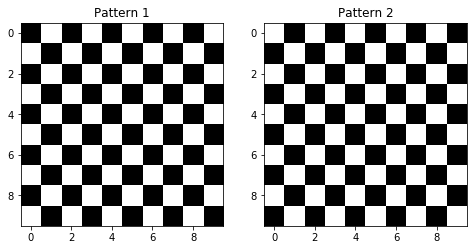

Similarity between the two patterns:  1.0


In [19]:
# chessboard
chess = [np.zeros(N)-1 for j in range(2)]
c = np.array([np.zeros((L,L))-1 for j in range(2)])

for i in range(2):
    if i == 0:
        c[i][::2, ::2] = 1
        c[i][1::2, 1::2] = 1
    else:
        c[i][1::2, ::2] = 1
        c[i][::2, 1::2] = 1
    chess[i] = c[i].reshape(1,N)[0]

err_chess = []   

fig, ax = plt.subplots(1, 2, figsize=(8,4))

ax[0].set_title('Pattern 1')
ax[0].imshow(chess[0].reshape(L,L),cmap='Greys')
ax[1].set_title('Pattern 2')
ax[1].imshow(chess[1].reshape(L,L),cmap='Greys')
plt.show()    
    
for i in chess:    
    err_chess.append(w_sim(chess[0],i,2))

print("Similarity between the two patterns: ", err_chess[1])

In [20]:
# we try our algorithm to see if the two chessboards are distinguishable.

chess = np.array(chess)
ind = [0,1]

for idx in ind: 
    for MF in range(2):
        if MF: J = MF_coupling(chess,N)
        else: J = R_coupling(chess,N,R)

        sys = deepcopy(chess[idx])

        sys = montecarlo(J, sys, 25, 500)
        wrong_pixels = error_im(chess[idx],sys)
        assigned_pattern = assign_pattern(chess,sys)

#         fig, ax = plt.subplots(1,2, figsize = (8,5))
#         ax[0].set_title('Pattern')
#         ax[0].imshow(chess[idx].reshape(L,L), cmap='Greys')
#         ax[1].set_title('Finishing configuration')
#         ax[1].imshow(sys.reshape(L,L), cmap='Greys')
#         plt.show()
        print('The error of the algorithm using MF = %i is %f' %(MF, wrong_pixels))
        print('The algorithm recognised the pattern %i and the correct pattern is %i\n' %(assigned_pattern,idx))

The error of the algorithm using MF = 0 is 0.000000
The algorithm recognised the pattern 0 and the correct pattern is 0

The error of the algorithm using MF = 1 is 0.000000
The algorithm recognised the pattern 0 and the correct pattern is 0

The error of the algorithm using MF = 0 is 0.000000
The algorithm recognised the pattern 1 and the correct pattern is 1

The error of the algorithm using MF = 1 is 0.000000
The algorithm recognised the pattern 1 and the correct pattern is 1



On the contrary of what we thought, the distance criteria is not a good one to define similar patterns, as our algorithm can distinguish with no error the two chessboards. 

Hence, a new approach needs to be applied: an intuitive idea is that two patterns might be similar when they have only a few different pixels. As a consequence, we try with some regularly shaped patterns where the number of different pixels can be easily counted.

In order to apply this idea, we choose some "frames" with shrinking size and some straight vertical lines moving along the grid and we perform the algorithm using them as patterns. Moreover we try our algorithm with random generated patterns with only $10$ black pixels.

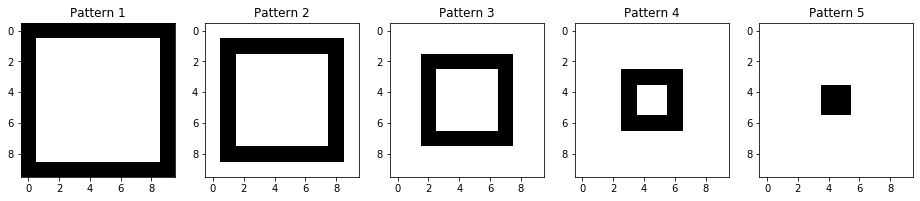

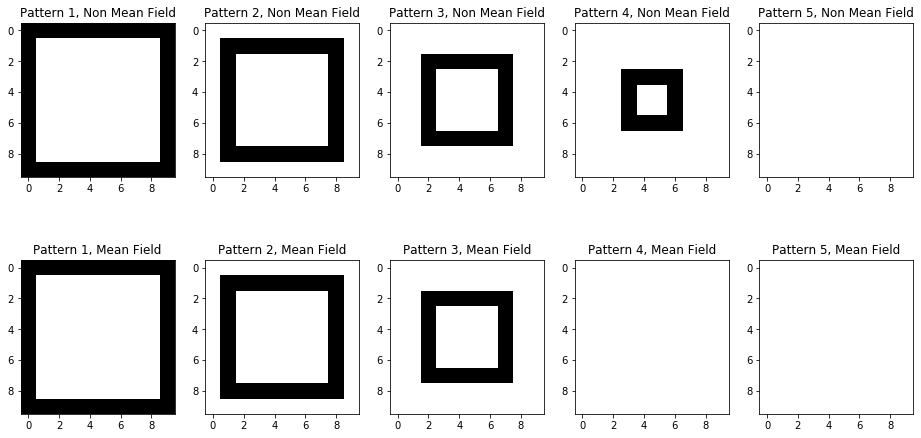

In [21]:
# frames
frames = [np.zeros(N)-1 for j in range((L+1)//2)]

for i in range((L+1)//2):
    for j in range(N):
        if j%L == i:
            frames[i][j] = 1
        if j%L == (L-i-1) :
            frames[i][j] = 1
        if j//L == i:
            frames[i][j] = 1
        if j//L == (L-i-1) :
            frames[i][j] = 1
    for k in range(i):
        for j in range(N):
            if j%L == k:
                frames[i][j] = -1
            if j%L == (L-k-1) :
                frames[i][j] = -1
            if j//L == k:
                frames[i][j] = -1
            if j//L == (L-k-1) :
                frames[i][j] = -1

fig, ax = plt.subplots(1, (L+1)//2 , figsize=(16,6))

for i in range((L+1)//2):
    ax[i].set_title('Pattern %i' %(i+1))
    ax[i].imshow(frames[i].reshape(L,L),cmap='Greys')
plt.show()    

frames = np.array(frames)
ind = np.arange(len(frames))

images = [[],[]]

for idx in ind: 
    for MF in range(2):
        if MF: J = MF_coupling(frames,N)
        else: J = R_coupling(frames,N,R)

        sys = deepcopy(frames[idx])

        sys = montecarlo(J, sys, 25, 500)
        wrong_pixels = error_im(frames[idx],sys)
        assigned_pattern = assign_pattern(frames,sys)
        images[MF].append(sys)
        
#         print('The error of the algorithm using MF = %i is %f' %(MF, wrong_pixels))
#         print('The algorithm recognised the pattern %i and the correct pattern is %i\n' %(assigned_pattern,idx))

fig, ax = plt.subplots(2, (L+1)//2 , figsize=(16,8))

for i in range((L+1)//2):
    ax[0][i].set_title('Pattern %i, Non Mean Field' %(i+1))
    ax[0][i].imshow(images[0][i].reshape(L,L),cmap='Greys')
    ax[1][i].set_title('Pattern %i, Mean Field' %(i+1))
    ax[1][i].imshow(images[1][i].reshape(L,L),cmap='Greys')
plt.show() 


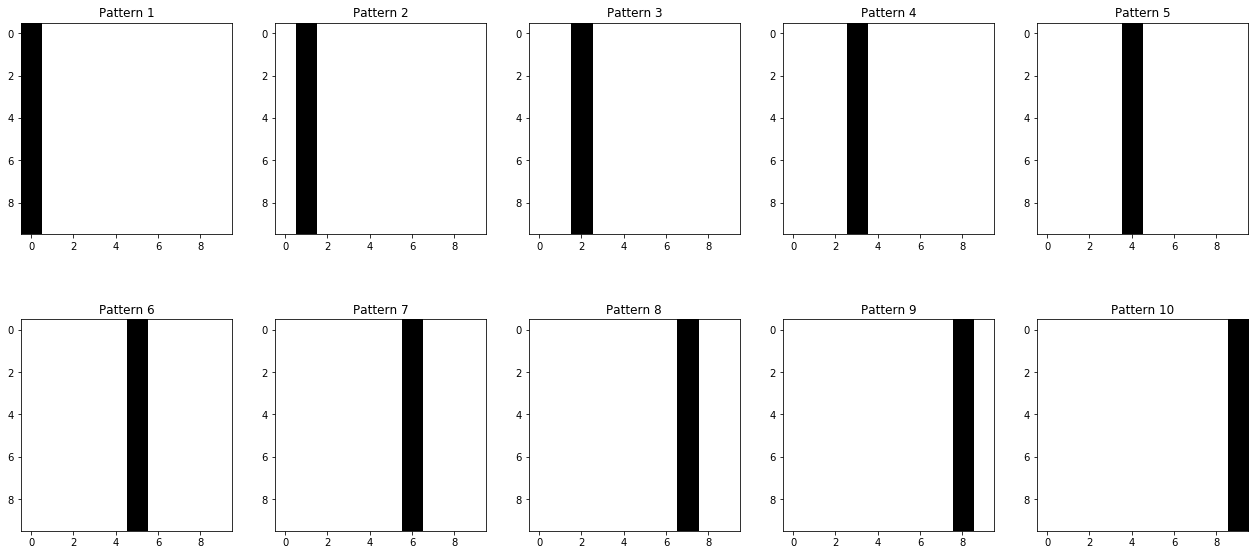

The error of the algorithm using MF = 0 is 0.100000
The algorithm recognised the pattern 0 and the correct pattern is 0

The error of the algorithm using MF = 1 is 0.100000
The algorithm recognised the pattern 0 and the correct pattern is 0

The error of the algorithm using MF = 0 is 0.100000
The algorithm recognised the pattern 0 and the correct pattern is 1

The error of the algorithm using MF = 1 is 0.090000
The algorithm recognised the pattern 1 and the correct pattern is 1

The error of the algorithm using MF = 0 is 0.100000
The algorithm recognised the pattern 0 and the correct pattern is 2

The error of the algorithm using MF = 1 is 0.100000
The algorithm recognised the pattern 0 and the correct pattern is 2

The error of the algorithm using MF = 0 is 0.100000
The algorithm recognised the pattern 0 and the correct pattern is 3

The error of the algorithm using MF = 1 is 0.100000
The algorithm recognised the pattern 0 and the correct pattern is 3

The error of the algorithm using

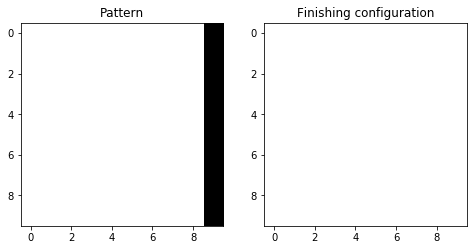

In [22]:
# straight verical lines patterns

patt = [np.zeros(N)-1 for j in range(L)]
for i in range(L):
    for j in range(L):
        patt[i][i+L*j]=1


fig, ax = plt.subplots(2, int(len(patt)/2), figsize=(22,10))

for i in range(int(len(patt)/2)):
    ax[0][i].set_title('Pattern %i' %(i+1))
    ax[0][i].imshow(patt[i].reshape(L,L),cmap='Greys')
    ax[1][i].set_title('Pattern %i' %(i+int(len(patt)/2)+1))
    ax[1][i].imshow(patt[i+int(len(patt)/2)].reshape(L,L),cmap='Greys')
plt.show()

# we try our algorithm to see if the patterns are distinguishable.

patt = np.array(patt)
ind = np.arange(len(patt))

for idx in ind: 
    for MF in range(2):
        if MF: J = MF_coupling(patt,N)
        else: J = R_coupling(patt,N,R)

        sys = deepcopy(patt[idx])

        sys = montecarlo(J, sys, 25, 500)
        wrong_pixels = error_im(patt[idx],sys)
        assigned_pattern = assign_pattern(patt,sys)

#         fig, ax = plt.subplots(1,2, figsize = (8,5))
#         ax[0].set_title('Pattern')
#         ax[0].imshow(patt[idx].reshape(L,L), cmap='Greys')
#         ax[1].set_title('Finishing configuration')
#         ax[1].imshow(sys.reshape(L,L), cmap='Greys')
#         plt.show()
        print('The error of the algorithm using MF = %i is %f' %(MF, wrong_pixels))
        print('The algorithm recognised the pattern %i and the correct pattern is %i\n' %(assigned_pattern,idx))
        
fig, ax = plt.subplots(1,2, figsize = (8,5))
ax[0].set_title('Pattern')
ax[0].imshow(patt[-1].reshape(L,L), cmap='Greys')
ax[1].set_title('Finishing configuration')
ax[1].imshow(sys.reshape(L,L), cmap='Greys')
plt.show()


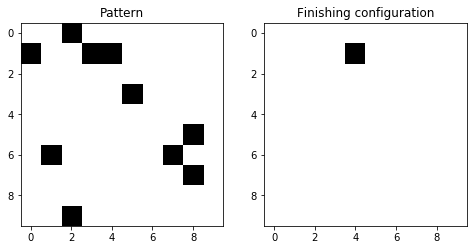

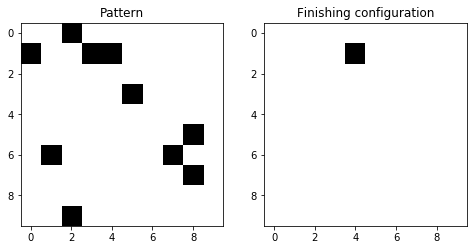

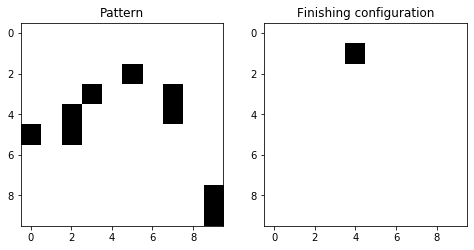

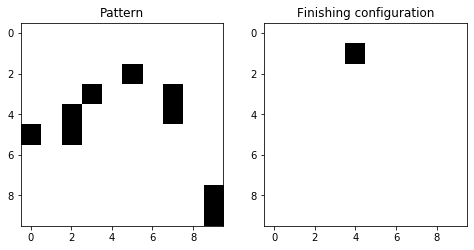

In [24]:
# random
diff = [np.zeros(N)-1 for j in range(5)]

for i in range(5):
    for j in range(L):
        k = np.random.randint(0,N)
        diff[i][k] = 1
        

diff = np.array(diff)
ind = np.arange(len(diff))

for idx in ind: 
    for MF in range(2):
        if MF: J = MF_coupling(diff,N)
        else: J = R_coupling(diff,N,R)

        sys = deepcopy(diff[idx])

        sys = deterministic_hopfield(sys,100)
        wrong_pixels = error_im(diff[idx],sys)
        assigned_pattern = assign_pattern(diff,sys)
        if idx == 0 or idx == len(diff)-1:
            fig, ax = plt.subplots(1,2, figsize = (8,5))
            ax[0].set_title('Pattern')
            ax[0].imshow(diff[idx].reshape(L,L), cmap='Greys')
            ax[1].set_title('Finishing configuration')
            ax[1].imshow(sys.reshape(L,L), cmap='Greys')
        plt.show()
#         print('The error of the algorithm is %f' %(wrong_pixels))
#         print('The algorithm recognised the pattern %i and the correct pattern is %i' %(assigned_pattern,idx))


In these three examples we have seen that not all patterns are recognised:
- the frames show a flaw in the recognition after a certain point;
- the lines are never correctly classified: the system falls into the same minimum every time;
- the random patterns also fall always in the same minimum, but it is different from the others.
This behaviour is not impossible, as our system is frustrated: not all the spins can be in their optimal state and there is the possibility that stronger equilibria suppress the weaker ones.

The first thing to do is to understand why that configuration is a minimum, since it is not one of the given patterns. 

Our guess is to look at the mean of the patterns, and indeed it proves to be the right one.

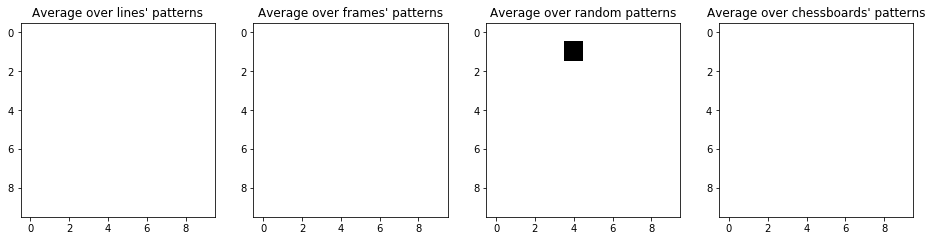

In [25]:
fig, ax = plt.subplots(1,4, figsize = (16,5))
ax[0].set_title('Average over lines\' patterns')
ax[0].imshow(np.sign(patt.mean(axis=0)).reshape(L,L), cmap='Greys')
ax[1].set_title('Average over frames\' patterns')
ax[1].imshow(np.sign(frames.mean(axis=0)).reshape(L,L), cmap='Greys')
ax[2].set_title('Average over random patterns')
ax[2].imshow(np.sign(diff.mean(axis=0)).reshape(L,L), cmap='Greys')
ax[3].set_title('Average over chessboards\' patterns')
ax[3].imshow(np.sign(chess.mean(axis=0)).reshape(L,L), cmap='Greys')

We need to find a quantitative way to describe this similarity and to know if $p$ patterns are similar without running the algorithm. Since we are talking about a physical system, the proper parameter to define the similarity can be the energy. 

Our hypothesis is that if the average of the possible $p$ patterns has the lowest energy, then the set of considered $p$ patterns is similar.

In [26]:
J_fr = R_coupling(frames, N, R)
J_patt = R_coupling(patt, N, R)
J_diff = R_coupling(diff, N, R)
J_chess = R_coupling(chess, N, R)

energy_fr = []
energy_patt = []
energy_diff = []
energy_chess = []

for i in frames:
    energy_fr.append( H(J_fr, i) )
energy_fr.append(H(J_fr,np.sign(frames.mean(axis=0)) ) )

for i in patt:
    energy_patt.append( H(J_patt, i) )
energy_patt.append(H(J_patt,np.sign(patt.mean(axis=0)) ) )

for i in diff:
    energy_diff.append( H(J_diff, i) )
energy_diff.append(H(J_diff,np.sign(diff.mean(axis=0)) ) )

for i in chess:
    energy_chess.append( H(J_chess, i) )
energy_chess.append(H(J_chess,np.sign(chess.mean(axis=0)) ) )


Text(0.5, 0, 'Number of pattern')

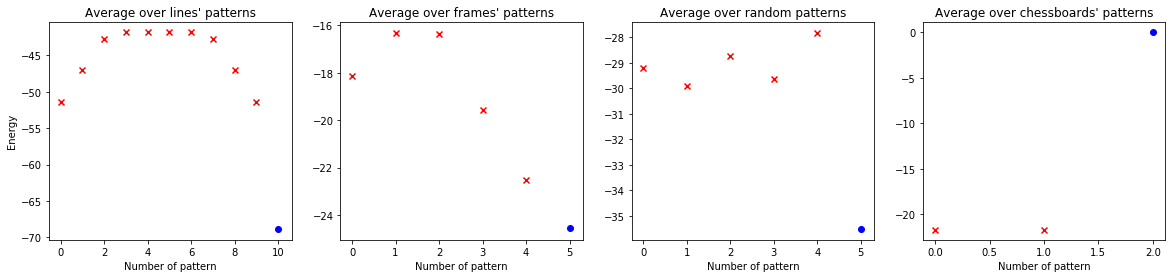

In [27]:
fig, ax = plt.subplots(1,4, figsize = (20,4))

ax[0].set_title('Average over lines\' patterns')
ax[0].scatter(np.arange(10),energy_patt[:10], marker='x', c='r')
ax[0].scatter(10, energy_patt[10], marker='o', c='b')
ax[0].set_ylabel("Energy")
ax[0].set_xlabel("Number of pattern")

ax[1].set_title('Average over frames\' patterns')
ax[1].scatter(np.arange(5),energy_fr[:5], marker='x', c='r')
ax[1].scatter(5, energy_fr[5], marker='o', c='b')
ax[1].set_xlabel("Number of pattern")

ax[2].set_title('Average over random patterns')
ax[2].scatter(np.arange(5), energy_diff[:5], marker='x', c='r')
ax[2].scatter(5, energy_diff[5], marker='o', c='b')
ax[2].set_xlabel("Number of pattern")

ax[3].set_title('Average over chessboards\' patterns')
ax[3].scatter(np.arange(2),energy_chess[:2], marker='x', c='r')
ax[3].scatter(2, energy_chess[2], marker='o', c='b')
ax[3].set_xlabel("Number of pattern")


In conclusion, we proved that our guess was correct, and we found a criteria to predict whether a set of $p$ patterns is undistinguishable for the Hopfield model.

# Hand written digits

Up to now, we have seen that our model recongize the simplest data that we generated. Now, we want to take a step further and try to implement the model in a more sophisticated dataset: the MINST. 

The MINST is a large database of handwritten digits of size 28x28 pixels that is commonly used for training various image processing. The aim of this section is to identify correctly the digits using the Hopfield Model. 

We will just use the test set to run our analysis since it is way smaller than the train one, but still have enough data to give meaningful results.

In [28]:
#Convert image to pixel
#The value 0.2 was chosen arbitrary by considering the grey scale of the image. 
def from_minst_to_spin(X):
    X = X/255 # Normalizing the values 
    X[ X<0.2 ] = -1  
    X[ X>=0.2 ] = 1
    return X

In [29]:
data_test = pd.read_csv('./mnist_test.csv')
#data_train = pd.read_csv('./mnist_train.csv')

L = 28
N = L**2

In [ ]:
label_train = []
digits_train = []
for i in range(data_train.shape[0]):
    a = np.array( data_train.iloc[ [i] ])
    label_train.append( a[0][0]) # Taking the digit
    digits_train.append( a[0][1:] ) # Taking the image of the digit

label_train = np.array(label_train)
digits_train = np.array(digits_train)
X_train = from_minst_to_spin(digits_train) 

In [30]:
label_test = []
digits_test = []
for i in range(data_test.shape[0]):
    a = np.array( data_test.iloc[ [i] ])
    label_test.append( a[0][0]) # Taking the digit
    digits_test.append( a[0][1:] ) # Taking the image of the digit

label_test = np.array(label_test)
digits_test = np.array(digits_test)
X_test = from_minst_to_spin(digits_test)


The first thing that needs to be done is to decide which are the possible patterns of the Hopfield model. It seems reasonable to take the average of the images representing the same digit.

In [31]:
# Try with patterns that are the average over all the digits.
# For example take the all 0, sum over the pixel and divide for the number of images.
# If the value is negative -> -1, the other case 1
mean_patterns = []
for i in range(10):
    mean_patterns.append( np.sign(X_test[ label_test == i ].sum(axis=0)) )
mean_patterns = np.array(mean_patterns)

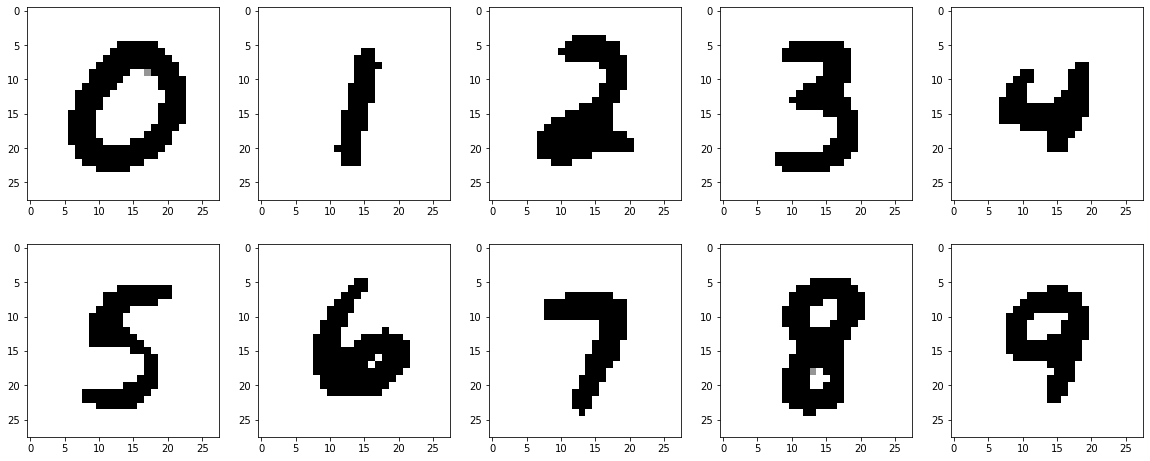

In [32]:
fig, ax = plt.subplots(2, 5, figsize=(20,8))

for i in range(5):
    ax[0][i].imshow( mean_patterns[i].reshape(L,L), cmap='Greys' )
    ax[1][i].imshow( mean_patterns[i+5].reshape(L,L), cmap='Greys' )


The error of the algorithm is 0.127551
The algorithm recognised the pattern 9 and the correct pattern is 6


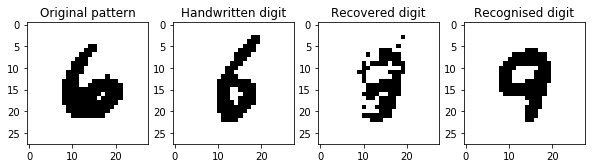

In [33]:
# we use MF Montecarlo
idx = np.random.randint(0,9999)
dgt = label_test[idx]

J = MF_coupling(mean_patterns, N)
sys = X_test[idx]

res = montecarlo(J,sys,25,1000)

wrong_pixels = error_im(mean_patterns[dgt],res)
assigned_pattern = assign_pattern(mean_patterns,res)

fig, ax = plt.subplots(1,4, figsize=(10,6))
ax[0].set_title('Original pattern')
ax[0].imshow(mean_patterns[dgt].reshape(L,L),cmap='Greys')
ax[1].set_title('Handwritten digit')
ax[1].imshow(sys.reshape(L,L),cmap='Greys')
ax[2].set_title('Recovered digit')
ax[2].imshow(res.reshape(L,L),cmap='Greys')
ax[3].set_title('Recognised digit')
ax[3].imshow(mean_patterns[assigned_pattern].reshape(L,L),cmap='Greys')
print('The error of the algorithm is %f' %(wrong_pixels))
print('The algorithm recognised the pattern %i and the correct pattern is %i' %(assigned_pattern,dgt))

As it can be seen the recovered digit is strangely shaped, and multiple runs outline that the recognised digit is always the same: our set of patterns is undistinguishable for our algorithm with the previoulsy explained meaning. Hence, a suitable choice of the patterns must be done: firstly, we decide to "zip" the images in order to have less pixels to analyze.

Another important reason to zip the image is the gaining in term of time implementation: we will at least divide that time by $4$.

## Zipping the images

The zipping function takes batches of four pixels and from them creates a single pixel
that is black even if only one of the four is black. This divides by 4 the resolution of the image, lowering the size of the system from 28x28 to 14x14.

This is a common technique used in neural networks when several features are involved: indeed the choice of generating a black pixel, even if only one in four is black, is given by the different relevance that the two colors have in the MNIST problem. The white pixels are only background, and the blacks contain the actual data.

In [34]:
def zipping(sys1):
    sys = deepcopy(sys1)
    N = sys.shape[0]
    L = int(np.sqrt(N))
    sys = sys.reshape(L,L)
    zipp = np.array([-1 for i in range(N//4)]).reshape(L//2,L//2)
    for i in np.arange(0, L, 2):
        for j in np.arange(0, L, 2):
            if sys[i][j] + sys[i+1][j] + sys[i][j+1] + sys[i+1][j+1] > -4:
                zipp[i//2,j//2] = 1
    zipp = zipp.reshape(1,N//4)
    return zipp[0]

In [35]:
# we zip all the data
X_zip = []
for i in X_test:
    X_zip.append( zipping(i) )
X_zip = np.array(X_zip)

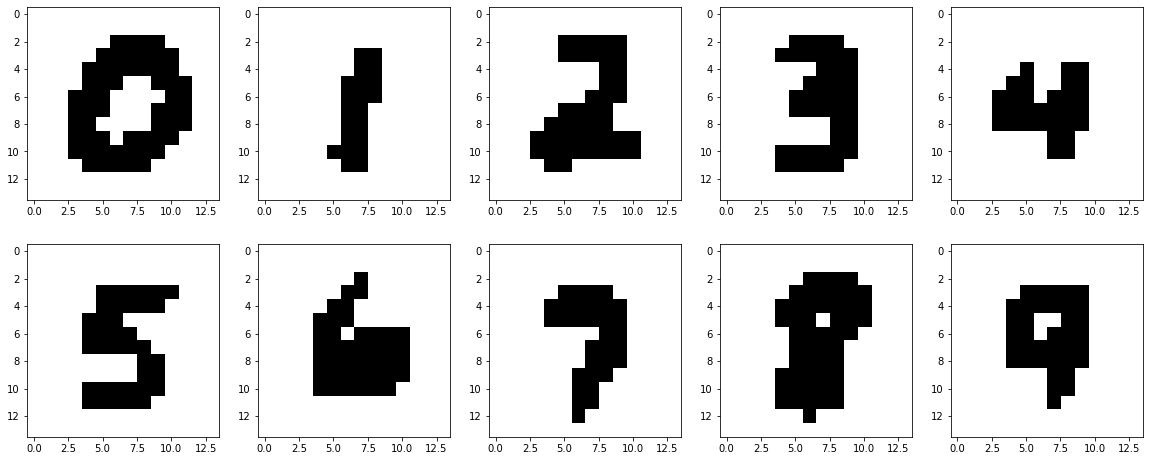

In [36]:
mean_zip = []

for i in mean_patterns:
    mean_zip.append( zipping(i) )
mean_zip = np.array(mean_zip)

fig, ax = plt.subplots(2, 5, figsize=(20,8))

for i in range(5):
    ax[0][i].imshow( mean_zip[i].reshape(L//2,L//2), cmap='Greys' )
    ax[1][i].imshow( mean_zip[i+5].reshape(L//2,L//2), cmap='Greys' )


In [37]:
J = R_coupling(mean_zip, N//4, 7)

The error of the algorithm is 0.086735
The algorithm recognised the pattern 9 and the correct pattern is 4


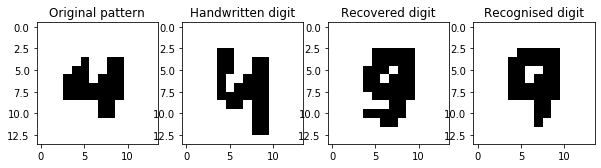

In [38]:
idx = np.random.randint(0,9999)
dgt = label_test[idx]

sys = X_zip[idx]

new = montecarlo(J,sys,25,1000)
#res = deterministic_hopfield(sys, 100)

wrong_pixels = error_im(mean_zip[dgt],new)
assigned_pattern = assign_pattern(mean_zip,new)


fig, ax = plt.subplots(1,4, figsize=(10,6))
ax[0].set_title('Original pattern')
ax[0].imshow(mean_zip[dgt].reshape(L//2,L//2),cmap='Greys')
ax[1].set_title('Handwritten digit')
ax[1].imshow(sys.reshape(L//2,L//2),cmap='Greys')
ax[2].set_title('Recovered digit')
ax[2].imshow(new.reshape(L//2,L//2),cmap='Greys')
ax[3].set_title('Recognised digit')
ax[3].imshow(mean_zip[assigned_pattern].reshape(L//2,L//2),cmap='Greys')
print('The error of the algorithm is %f' %(wrong_pixels))
print('The algorithm recognised the pattern %i and the correct pattern is %i' %(assigned_pattern,dgt))

Even if zipping the images reduces the implementation time, it does not solve the problem of the strange new minimum. Thus, we will see if the given patterns are stable.

## Find the real minima of the system

To find all the minima of the system we start from the mean patterns: from the theory we are sure that they should be the only minima of the system. Indeed we know that it is not totally true from the similarity analysis.

We will so see if the given pattern are stable, and if not in which minimum they fall. We will also print the average of those patterns, to see if the theory presented above is still valid.

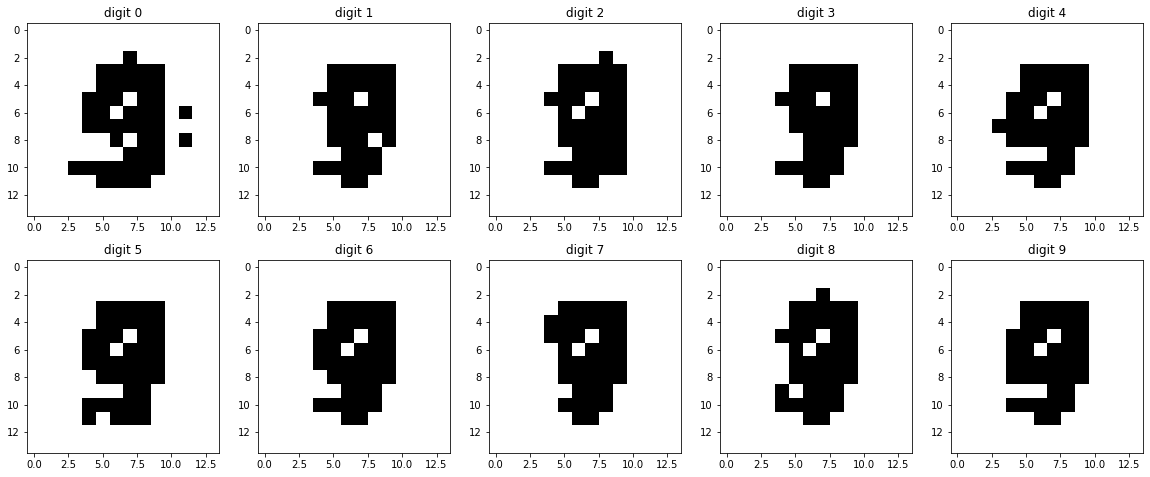

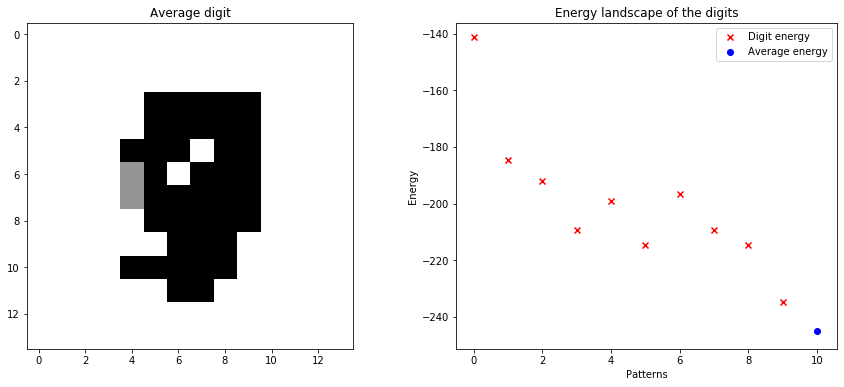

In [39]:
minima = []

for k in mean_zip:
    res = montecarlo(J, k, 25, 500)
    minima.append(res)

minima = np.array(minima)

fig, ax = plt.subplots(2, 5, figsize=(20,8))

for i in range(5):
    ax[0][i].set_title('digit %i' %i)
    ax[0][i].imshow( minima[i].reshape(L//2,L//2), cmap='Greys' )
    ax[1][i].set_title('digit %i' %(i+5))
    ax[1][i].imshow( minima[i+5].reshape(L//2,L//2), cmap='Greys' )
plt.show()

energy_dig = []

for i in mean_zip:
    energy_dig.append( H(J, i) )
energy_dig.append(H(J,np.sign(mean_zip.mean(axis=0)) ) )

fig, ax = plt.subplots(1, 2, figsize=(15,6))
ax[0].set_title('Average digit')
ax[0].imshow( np.sign(minima.mean(axis=0)).reshape(L//2,L//2), cmap='Greys' )
ax[1].set_title('Energy landscape of the digits')
ax[1].scatter(np.arange(len(energy_dig)-1),energy_dig[:len(energy_dig)-1], marker='x', c='r', label= 'Digit energy')
ax[1].scatter( len(energy_dig)-1, energy_dig[len(energy_dig)-1], marker='o', c='b', label= 'Average energy')
ax[1].set_xlabel("Patterns")
ax[1].set_ylabel('Energy')
ax[1].legend()
plt.show()

One can observe that all the minima found look almost the same: this means that the algorithm is unable to properly recognise the correct pattern, and we are in the very same situation discussed before. As a result, we develop a new method called "Hopfield chain".

## Hopfield-chain algorithm


Our model consist of several layers that are computed by observing the so called "error matrix". This matrix represent the rate of error in classifing the data comparing only two patterns at a time. In this way, we combine the most different patterns and make the algorithm choose between the most easily distinguishable ones.

In [40]:
err_mat = []
for i in range(10):
    err_mat.append([])
    for j in range(10):
        err_mat[i].append( round(error_im(mean_zip[i], mean_zip[j]),2) )
err_mat = np.array(err_mat).reshape(10,10)
err_mat

array([[0.  , 0.29, 0.21, 0.2 , 0.25, 0.16, 0.2 , 0.23, 0.17, 0.22],
       [0.29, 0.  , 0.18, 0.15, 0.16, 0.16, 0.18, 0.11, 0.17, 0.15],
       [0.21, 0.18, 0.  , 0.12, 0.18, 0.18, 0.15, 0.19, 0.12, 0.16],
       [0.2 , 0.15, 0.12, 0.  , 0.19, 0.09, 0.19, 0.14, 0.12, 0.15],
       [0.25, 0.16, 0.18, 0.19, 0.  , 0.17, 0.12, 0.14, 0.19, 0.06],
       [0.16, 0.16, 0.18, 0.09, 0.17, 0.  , 0.15, 0.14, 0.12, 0.12],
       [0.2 , 0.18, 0.15, 0.19, 0.12, 0.15, 0.  , 0.17, 0.17, 0.12],
       [0.23, 0.11, 0.19, 0.14, 0.14, 0.14, 0.17, 0.  , 0.13, 0.09],
       [0.17, 0.17, 0.12, 0.12, 0.19, 0.12, 0.17, 0.13, 0.  , 0.13],
       [0.22, 0.15, 0.16, 0.15, 0.06, 0.12, 0.12, 0.09, 0.13, 0.  ]])

In [41]:
# Selecting couples with higher differences
best = []
for i in range(10):
    best.append( [i ,np.argmax( err_mat[i] )] )

# Eliminating symmetric couples
best = np.unique(np.sort(best, axis=1), axis=0)

best

array([[0, 1],
       [0, 2],
       [0, 3],
       [0, 4],
       [0, 6],
       [0, 7],
       [0, 9],
       [2, 5],
       [4, 8]], dtype=int64)

In [42]:
# Computing the couplings for the various connections
Ji = []
for i in best:
    patt = np.array( [  mean_zip[i[0]], mean_zip[i[1]] ] )
    Ji.append( R_coupling( patt ,N//4, 7) ) 

## Average for each digits

Now it is important to set a threshold error between layers. In order to derive it, we compute the speed of convergence for each digit as a function of the number of iterations. 
Finding the optimal value is crucial to avoid the incorrect classification of different patterns (i.e. all the patterns falling in the same minimum).
We so first compute the speed of convergence of each digit in its layer, and then the speed of convergence of each digit in the first layer ( and so in a layer that doesn't have access to the correct classification).

In [ ]:
# Look at different digit convergence time
ordered_digits = []
for i in range(10):
    ordered_digits.append( X_zip[ label_test == i ] )

iterations = np.arange(200,600,50)

err = []
err_dev = []

for i in range(10): # cycle over the digits
    err.append( [] )
    err_dev.append( [] )
    for t in iterations: # cycle over iterations
        temp_err = []
        for n in range(10): # iterations
            for j in range(len(best)): # Selection of correct coupling
                if i in best[j]:
                    sys = ordered_digits[i][n]
                    res = montecarlo(Ji[j], sys ,25 , t)
                    wrong_pixels = error_im(mean_zip[i], res)
                    temp_err.append(wrong_pixels)
                    break
        temp_err = np.array(temp_err)
        err[i].append( temp_err.mean() )
        err_dev[i].append( temp_err.std() )

In [ ]:
fig = plt.figure( figsize=(10,6) )
for i in range(10):
    label = ('Digit %i' %i)
    plt.errorbar( iterations, err[i],fmt='--o', yerr=err_dev[i],  label = label )
plt.xlabel('Number of iterations')
plt.ylabel('Errors')
plt.legend(loc='best')
plt.title('Speed of convergence for each digit')

<img src=".\Images\mnist_samedigit.png">

A convergence of all the digits can be observed, and it can be noticed that the maximum error is very low ($\approx 7.5\%$). By observing the graph, this value is set as threshold and the number of iterations is fixed to $400$.

After that, we want to prove that the chosen values are correct, so we calculate the same plot but considering only the performances for every digit with respect to the first layer.

In [ ]:
diff_digits = []

for i in range(10):
    diff_digits.append( X_zip[ label_test == i ] )

iterations = np.arange(200,600,50)

err = []
err_dev = []

for i in range(2,10): # cycle over the digits
    err.append( [] )
    err_dev.append( [] )
    for t in iterations: # cycle over iterations
        temp_err = []
        for n in range(10): # iterations
            sys = ordered_digits[i][n]
            res = montecarlo(Ji[0], sys ,25 , t)
            wrong_pixels = error_im(mean_zip[i], res)
            temp_err.append(wrong_pixels)
        temp_err = np.array(temp_err)
        err[i-2].append( temp_err.mean() )
        err_dev[i-2].append( temp_err.std() )

In [ ]:
fig = plt.figure( figsize=(10,6) )
for i in range(2, 10):
    label = ('Digit %i' %i)
    plt.errorbar( iterations, err[i-2],fmt='--o', yerr=err_dev[i-2],  label = label )
plt.xlabel('Number of iterations')
plt.ylabel('Errors')
plt.legend(loc='best')
plt.title('Speed of convergence for each digit with respect to layer 0')

<img src='.\Images\minst_diffdigit.png'>

We can observe that every curve in the graph above is clearly over the chosen threshold of $0.075$ and that a divergence can be noticed, which is the expected result.

In [43]:
err = []
score = 0

for n in range(100):
    idx = np.random.randint(0, 9999)
    dgt = label_test[idx]

    for i in range(len(best)):
        sys = X_zip[idx]
        res = montecarlo(Ji[i], sys, 25, 400)

        wrong_pixels = error_im(mean_zip[dgt], res)

        if wrong_pixels > 0.075 and i<8: 
            continue
        patt = np.array( [  mean_zip[best[i][0]], mean_zip[best[i][1]] ] )
        assigned_pattern = assign_pattern(patt, res) 
        assigned_pattern = best[i][assigned_pattern] 
        break
    err.append(wrong_pixels)
    if assigned_pattern == dgt: score += 1

err = np.array(err)
score /= 100
print('The score of the algorithm is %f with an average error of %f' %(score, err.mean()))

The score of the algorithm is 0.930000 with an average error of 0.017398


In [ ]:
err = []
score = 0
for n in range(len(X_zip)):
    idx = n
    dgt = label_test[idx]

    for i in range(len(best)):
        sys = X_zip[idx]
        res = montecarlo(Ji[i], sys ,25 , 400)

        wrong_pixels = error_im(mean_zip[dgt], res)

        if wrong_pixels > 0.10 and i<8: 
            continue
        patt = np.array( [  mean_zip[best[i][0]], mean_zip[best[i][1]] ] )
        assigned_pattern = assign_pattern(patt, res) 
        assigned_pattern = best[i][assigned_pattern] 
        break
    err.append(wrong_pixels)
    if assigned_pattern == dgt: score += 1

err = np.array(err)
score /= len(X_zip)
print('The score of the algorithm is %f with an average error of %f' %(score, err.mean()))

# Conclusion 

In this project we underlined the capabilities and the flaws of the Hopfield model, by optimizing its parameters. 
As we expected, a similarity of the time implementation using MF and NMF was observed. On the other hand, we outlined the less fluctuations given by the MF. Moreover, we analyzed the influence of different types of noises on the performances of the algorithm, in order to get more accurate results.

We concluded that the Montecarlo simulation leads to better results than the deterministic update rule, as well as a greater efficency given by a much faster implementation time.

In addition, we saw that the mapping between the neural network and the physical system is well defined. According to this, we managed to describe the similarity between two patterns by using a physical quantity: the energy.

After a long detailed analysis of the basic theory behind the model, we finally tried it on a real world task: the recognition of the MNIST digits. The simulation was adapted by considering sets of layers corresponding to different coupled patterns. The algorithm gives indeed amazing results after some trials: we managed to classify correctly the $90\%$ of the digits, with an average error of $0.02\pm 0.03$, really close and compatible to zero. 
